# Send rate and latency versus Link Load parameter

This example experiment shows how to:

* how to run POOSL models with replaced system parameters
* collect the send rate and latency data from the POOSL simulations
* plot the trend of send rate and latency versus Link Load

In [3]:
# import the convenience utility to run parameterized POOSL models
import run_network_model

# Set up experiment
The experiment needs to know certain parameters: such as the name of the topology, what values it should use for the default model parameters, as well as the experiment values (in this case the link load).

In [ ]:
# set up the environment
import numpy
import itertools
from pathlib import Path

def dict_product(value: dict):
    return list(dict(zip(value.keys(), values)) for values in itertools.product(*value.values()))

In [ ]:
# Initialize template parameters, add different topologies here
# 10 evenly spaced values between 0.05 and 0.95
# NOTE: the output from linspace may show 0.50, but instead the real value is 0.4999994
# Therefore, the literal 0.50 cannot be used to look up the data! Use
# parameters["mesh"]["Load"][2] or similar to look up the values instead.
parameters = {
    "mesh": {
        "Load": numpy.linspace(0.05, 0.95, 10),
        "NIBufferCapacity": [2],
        "SoC_type": ["Mesh_2x2"],
    },
    "bus": {
        "Load": numpy.linspace(0.05, 0.95, 10),
        "NIBufferCapacity": [1, 4, 8, 16],
        "SoC_type": ["Bus_2_nodes", "Bus_4_nodes", "Bus_8_nodes", "Bus_16_nodes", "Bus_32_nodes", "Bus_64_nodes"],
    },
    "tree_buffers": {
        "Load": numpy.linspace(0.05, 0.95, 10),
        "NIBufferCapacity": [1, 4, 8, 16],
        "SoC_type": ["NetworkFatTree3LayerDegree2", "NetworkFatTree3LayerDegree2", "NetworkFatTree3LayerDegree2", "NetworkFatTree3LayerDegree2"],
    },
    "tree_layers": {
        "Load": numpy.linspace(0.05, 0.95, 10),
        "NIBufferCapacity": [4],
        "SoC_type": ["NetworkFatTree2LayerTest"]
        # , "NetworkFatTree3LayerTest", "NetworkFatTree4LayerTest", "NetworkFatTree5LayerTest"],
    },
    "tree_degrees": {
        "Load": numpy.linspace(0.05, 0.95, 10),
        "NIBufferCapacity": [1, 4, 8, 16],
        "SoC_type": ["NetworkFatTreeDegree5Terminals25", "NetworkFatTreeDegree4Terminals25", "NetworkFatTreeDegree3Terminals25", "NetworkFatTreeDegree2Terminals25"],
    },
}
parameters = dict(map(lambda x: (x[0], dict_product(x[1])), parameters.items()))

# Change this line to the chosen topology
# template_name = "mesh"
template_name = "bus"
# template_name = "torus"
# template_name = "tree"
# template_name = "tree_layers"
# template_name = "tree_buffers"
# template_name = "tree_degrees"

output_directory_base = Path(f"output/{template_name}")
selected_parameters = parameters[template_name]

# Put the absolute path to your model here; do not forget to change \ to / in the path on Windows
model_path = Path("../model").resolve()


## Run the parameterized models
Now we execute one model for every `Load` value in our experiment. The `load_value` variable ranges from 0.05 to 0.95 in 4 steps. 

The log files are stored in separate output directories, as the output directory depends on the load parameter. 

In [6]:
from multiprocessing import Pool
from tqdm.notebook import tqdm
import os


def dir_from_params(params: dict) -> Path:
    output_directory = output_directory_base
    for val in map(lambda x: x[1], sorted(list(params.items()), key=lambda x: x[0])):
        output_directory = output_directory / str(val)
    return output_directory


def get_all_params(model_parameters: dict):
    return (
        [model_path],
        open(f"templates/{template_name}_template.poosl").read(),
        model_parameters,
        dir_from_params(model_parameters),
    )


all_params = list(map(get_all_params, selected_parameters))
with Pool() as pool:
    for (errcode, error), p, directory in tqdm(
        pool.imap_unordered(run_network_model.run_network_model, all_params),
        total=len(all_params),
        desc="Evaluating all parameters",
    ):
        if errcode != 0:
            message = (
                f"Model with params {p} returned {errcode} and did not terminate to completion.\n"
                f"Check the output in {Path(directory).absolute()}\nLast error was:\n{error}"
            )
            print(message)
            raise Exception(message)

print("Experiment finished")

Evaluating all parameters:   0%|          | 0/240 [00:00<?, ?it/s]

Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-15:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  

## Define log file interpretation
All the simulations are finished, and their output is stored in separate directories.
We can now use those log files to fill the data tables (pandas DataFrames) by extracting the Point estimation data from the log files and inserting it into the table.

The function `readLog` defines how to read the Point estimation value from a `.log` file.

The last entry (i.e. the piece of text before the first tab) in the log file that can be converted to a Float will be used as the Point estimation for this log.

In [7]:
def read_log(fname: Path):
    if not fname.exists():
        raise Exception(f'Unable to read log: "{fname}" does not exist!')

    value = None
    with open(fname) as log_file:
        for line in log_file:
            parts = line.split("\t")
            try:
                value = float(parts[0].strip())
            except ValueError:
                pass
    return value


## Setup data tables
Here, we set up two tables (pandas DataFrame) in which we will store the results. Initially, the results are all unset, but we will read the relevant log files to find the Point estimations for the send rate and the latency for each node.

In [8]:
# set up the environment
import pandas as pd
import re

# prepare data structure
raw_data = []
model_indices = []
for model_parameters in selected_parameters:
    # dict iteration is random so we save the indexes in order that we encounter them
    model_indices.append(model_parameters)
    output_directory = dir_from_params(model_parameters)

    # Load all the latency and sendrate log files
    data_dict = {}
    for file in output_directory.glob("*.log"):
        pattern = r"([a-zA-Z]+)(\d+)"
        m = re.match(pattern, file.stem)
        if not m:
            continue
        data_dict[(m.group(1), m.group(2))] = read_log(file)
    raw_data.append(data_dict)

# Prepare pandas DataFrame
model_indices = pd.MultiIndex.from_frame(pd.DataFrame(model_indices)).reorder_levels([2, 1, 0])
data = pd.DataFrame(data=raw_data, index=model_indices)
data = data.reindex(sorted(data.columns), axis=1).sort_index()
data.columns = pd.MultiIndex.from_tuples(data.columns, names=["Type", "Node"])
data


Type                                 Latency                                \
Node                                       1        10        11        12   
SoC_type     NIBufferCapacity Load                                           
Bus_16_nodes 1                0.05  0.000834  0.000831  0.000829  0.000834   
                              0.15  0.001509  0.001441  0.001441  0.001427   
                              0.25  0.003303  0.003305  0.003305  0.003329   
                              0.35  0.006070  0.006028  0.006055  0.005915   
                              0.45  0.008198  0.008304  0.008361  0.008252   
...                                      ...       ...       ...       ...   
Bus_8_nodes  16               0.55  0.027753       NaN       NaN       NaN   
                              0.65  0.068090       NaN       NaN       NaN   
                              0.75  0.088560       NaN       NaN       NaN   
                              0.85  0.092572       NaN       NaN       NaN   
                              0.95  0.093902       NaN       NaN       NaN   

Type                                                                        \
Node                                      13        14        15        16   
SoC_type     NIBufferCapacity Load                                           
Bus_16_nodes 1                0.05  0.000836  0.000833  0.000832  0.000835   
                              0.15  0.001437  0.001441  0.001474  0.001443   
                              0.25  0.003270  0.003311  0.003275  0.003282   
                              0.35  0.005954  0.006075  0.006038  0.006033   
                              0.45  0.008264  0.008155  0.008293  0.008281   
...                                      ...       ...       ...       ...   
Bus_8_nodes  16               0.55       NaN       NaN       NaN       NaN   
                              0.65       NaN       NaN       NaN       NaN   
                              0.75       NaN       NaN       NaN       NaN   
                              0.85       NaN       NaN       NaN       NaN   
                              0.95       NaN       NaN       NaN       NaN   

Type                                        ... SendRate                      \
Node                                17  18  ...       59           6  60  61   
SoC_type     NIBufferCapacity Load          ...                                
Bus_16_nodes 1                0.05 NaN NaN  ...      NaN   14.725939 NaN NaN   
                              0.15 NaN NaN  ...      NaN   45.445761 NaN NaN   
                              0.25 NaN NaN  ...      NaN   72.993533 NaN NaN   
                              0.35 NaN NaN  ...      NaN   82.423752 NaN NaN   
                              0.45 NaN NaN  ...      NaN   83.801896 NaN NaN   
...                                 ..  ..  ...      ...         ...  ..  ..   
Bus_8_nodes  16               0.55 NaN NaN  ...      NaN  161.121115 NaN NaN   
                              0.65 NaN NaN  ...      NaN  167.497935 NaN NaN   
                              0.75 NaN NaN  ...      NaN  167.743033 NaN NaN   
                              0.85 NaN NaN  ...      NaN  168.520801 NaN NaN   
                              0.95 NaN NaN  ...      NaN  168.511110 NaN NaN   

Type                                                                    \
Node                                62  63  64           7           8   
SoC_type     NIBufferCapacity Load                                       
Bus_16_nodes 1                0.05 NaN NaN NaN   14.834223   15.603256   
                              0.15 NaN NaN NaN   44.637033   44.107810   
                              0.25 NaN NaN NaN   71.065775   71.113538   
                              0.35 NaN NaN NaN   85.282418   79.453083   
                              0.45 NaN NaN NaN   82.355805   80.916206   
...                                 ..  ..  ..         ...         ...   
Bus_8_nodes  16            

## Post-process and plot outcomes

We can apply all kinds of interesting post-processing on the tables, and plot some of the results.

The figures can be exported as png, pdf, ps, eps, svg, and pgf.


In [9]:
# compute the row-average of the Latency columns, and add it to the table
data["Latency", "average"] = data["Latency"].mean(axis=1)
data["SendRate", "average"] = data["SendRate"].mean(axis=1)
data

Type                                 Latency                                \
Node                                       1        10        11        12   
SoC_type     NIBufferCapacity Load                                           
Bus_16_nodes 1                0.05  0.000834  0.000831  0.000829  0.000834   
                              0.15  0.001509  0.001441  0.001441  0.001427   
                              0.25  0.003303  0.003305  0.003305  0.003329   
                              0.35  0.006070  0.006028  0.006055  0.005915   
                              0.45  0.008198  0.008304  0.008361  0.008252   
...                                      ...       ...       ...       ...   
Bus_8_nodes  16               0.55  0.027753       NaN       NaN       NaN   
                              0.65  0.068090       NaN       NaN       NaN   
                              0.75  0.088560       NaN       NaN       NaN   
                              0.85  0.092572       NaN       NaN       NaN   
                              0.95  0.093902       NaN       NaN       NaN   

Type                                                                        \
Node                                      13        14        15        16   
SoC_type     NIBufferCapacity Load                                           
Bus_16_nodes 1                0.05  0.000836  0.000833  0.000832  0.000835   
                              0.15  0.001437  0.001441  0.001474  0.001443   
                              0.25  0.003270  0.003311  0.003275  0.003282   
                              0.35  0.005954  0.006075  0.006038  0.006033   
                              0.45  0.008264  0.008155  0.008293  0.008281   
...                                      ...       ...       ...       ...   
Bus_8_nodes  16               0.55       NaN       NaN       NaN       NaN   
                              0.65       NaN       NaN       NaN       NaN   
                              0.75       NaN       NaN       NaN       NaN   
                              0.85       NaN       NaN       NaN       NaN   
                              0.95       NaN       NaN       NaN       NaN   

Type                                        ... SendRate                  \
Node                                17  18  ...       60  61  62  63  64   
SoC_type     NIBufferCapacity Load          ...                            
Bus_16_nodes 1                0.05 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.15 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.25 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.35 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.45 NaN NaN  ...      NaN NaN NaN NaN NaN   
...                                 ..  ..  ...      ...  ..  ..  ..  ..   
Bus_8_nodes  16               0.55 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.65 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.75 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.85 NaN NaN  ...      NaN NaN NaN NaN NaN   
                              0.95 NaN NaN  ...      NaN NaN NaN NaN NaN   

Type                                                                   \
Node                                         7           8          9   
SoC_type     NIBufferCapacity Load                                      
Bus_16_nodes 1                0.05   14.834223   15.603256  14.862549   
                              0.15   44.637033   44.107810  45.283748   
                              0.25   71.065775   71.113538  70.960210   
                              0.35   85.282418   79.453083  83.307444   
                              0.45   82.355805   80.916206  84.214661   
...                                        ...         ...        ...   
Bus_8_nodes  16               0.55  160.067773  164.161182        NaN   
                   

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') # select the ggplot style
from matplotlib.backends.backend_pdf import PdfPages

In [11]:
pdf = PdfPages(output_directory_base / 'graphs.pdf') # Open a file to write different graphs to; don't forget to close the PDF later!

In [12]:
# convenience function to create line plots in a single line, with some convenient default values
def line_plot(df, title, xlabel, ylabel, pdf=None):
    fig = df.plot.line(title=title, marker='s', figsize=(10,7))
    # use the line below instead on older versions if the margins are off
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if pdf is not None:
        pdf.savefig()
    return fig

# Because experiments can have different number of nodes, we only the load values of the current experiment
# this function is better combined with a call to groubpy to the dataframe with all the data
def extract_df(df):
    return df.droplevel([0, 1]).dropna(axis=1, how='all')

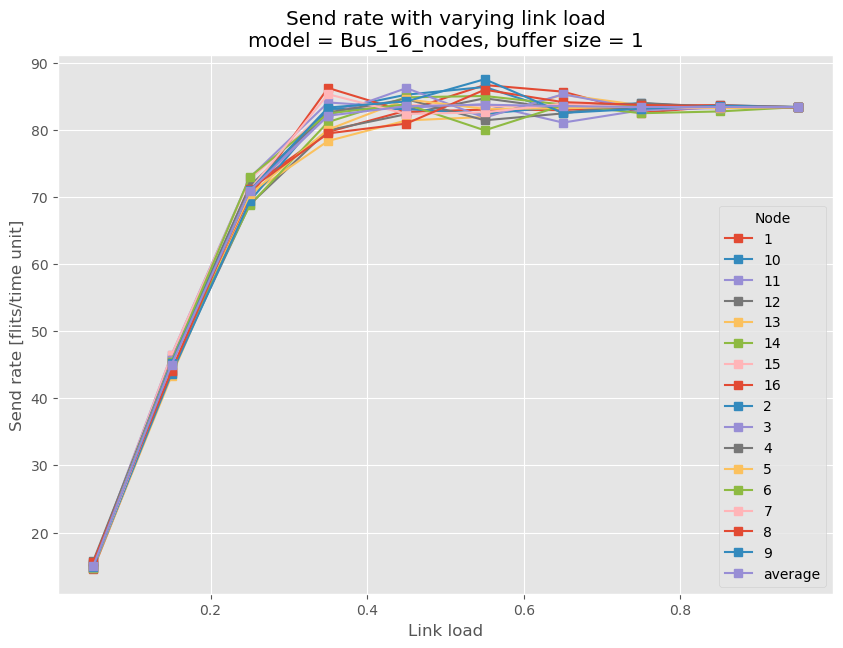

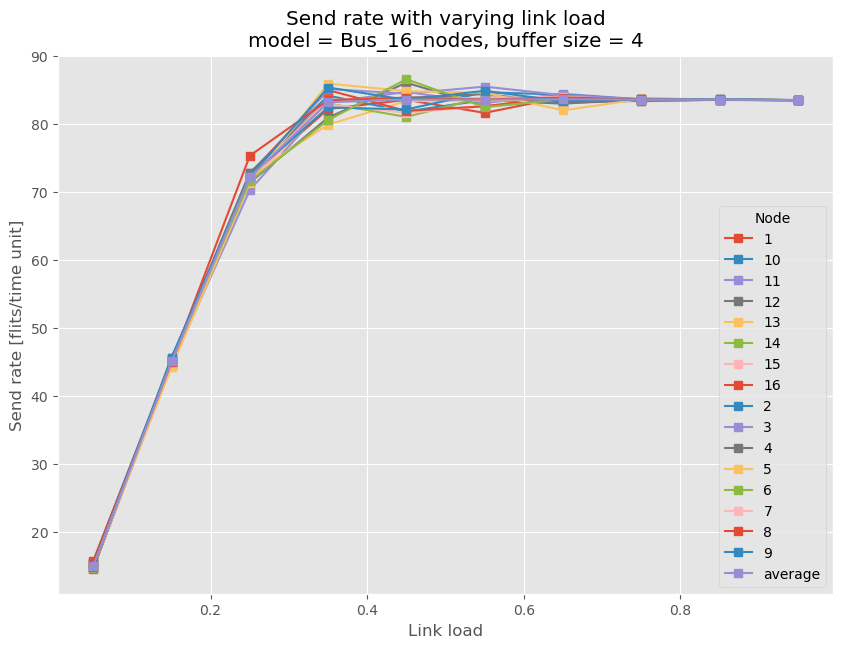

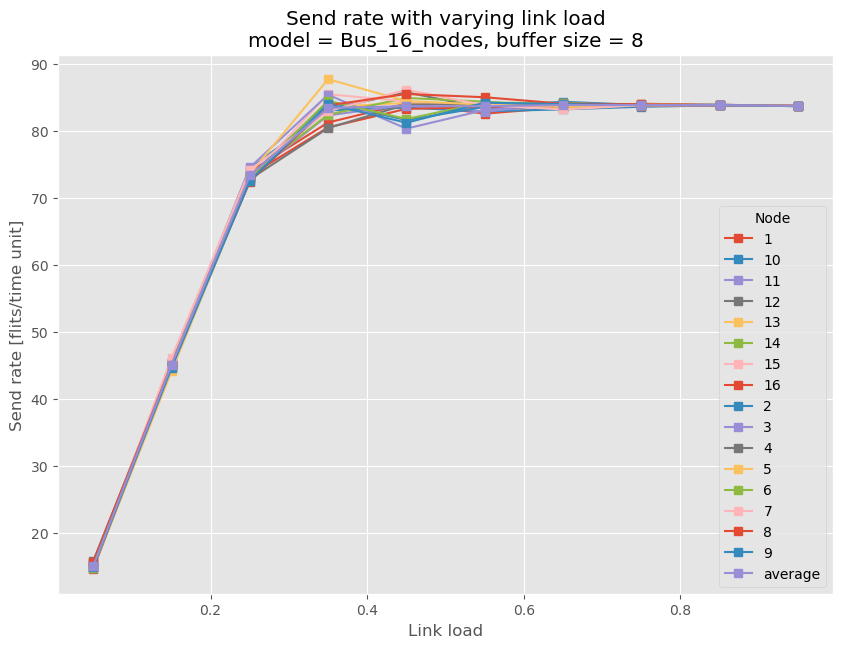

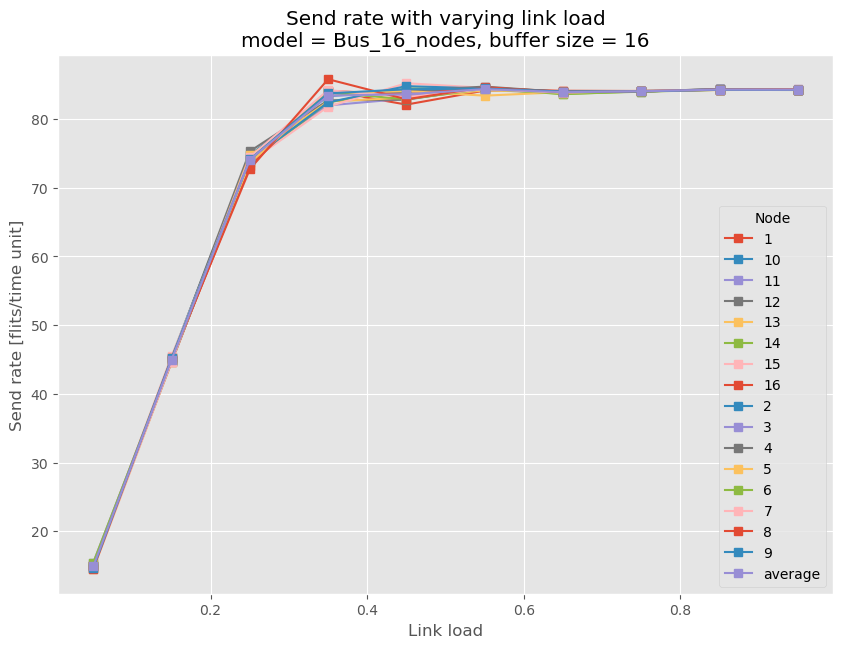

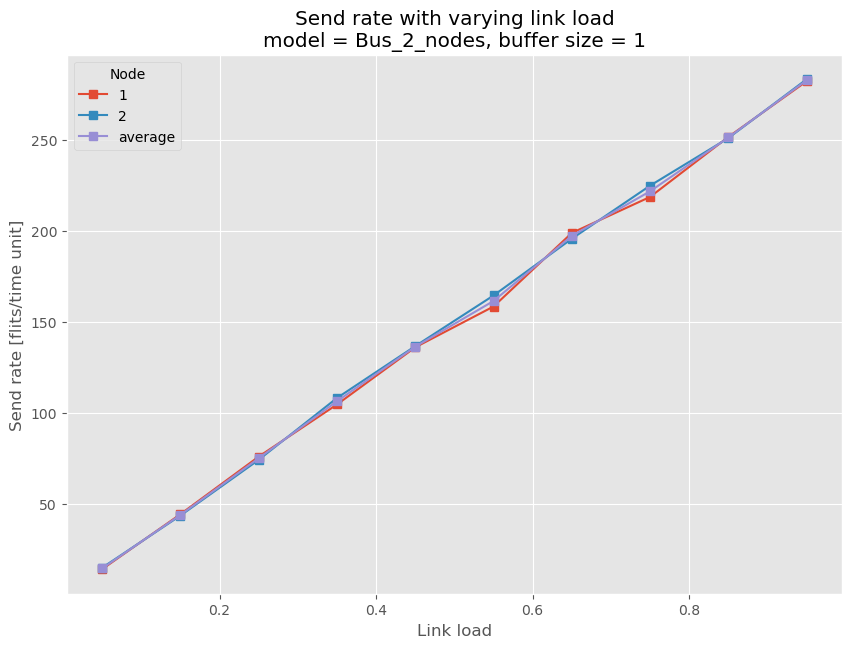

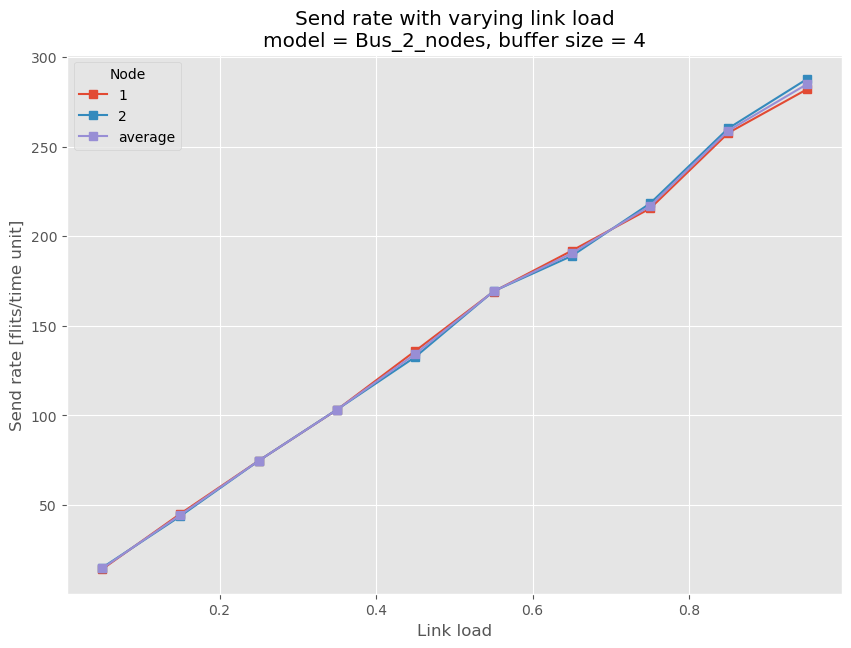

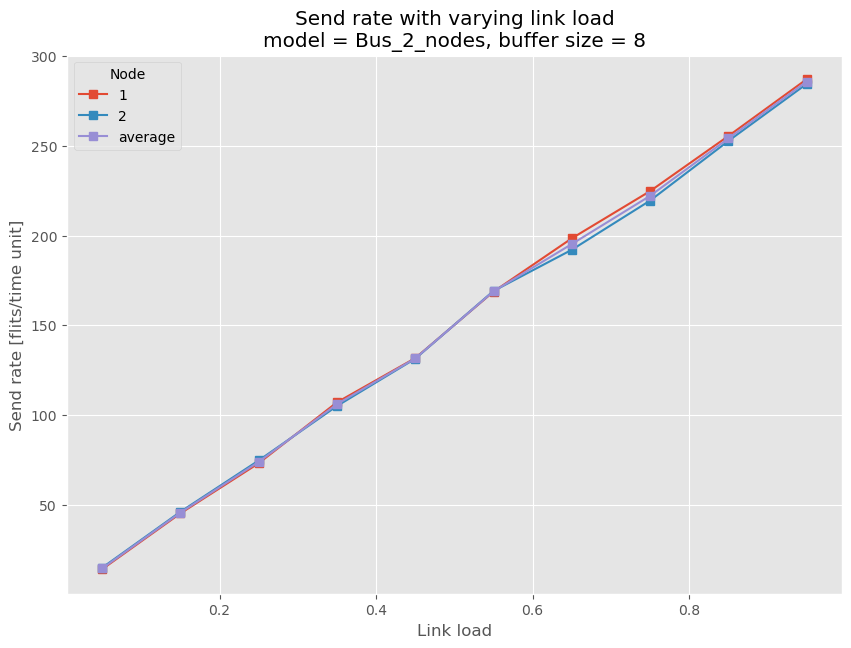

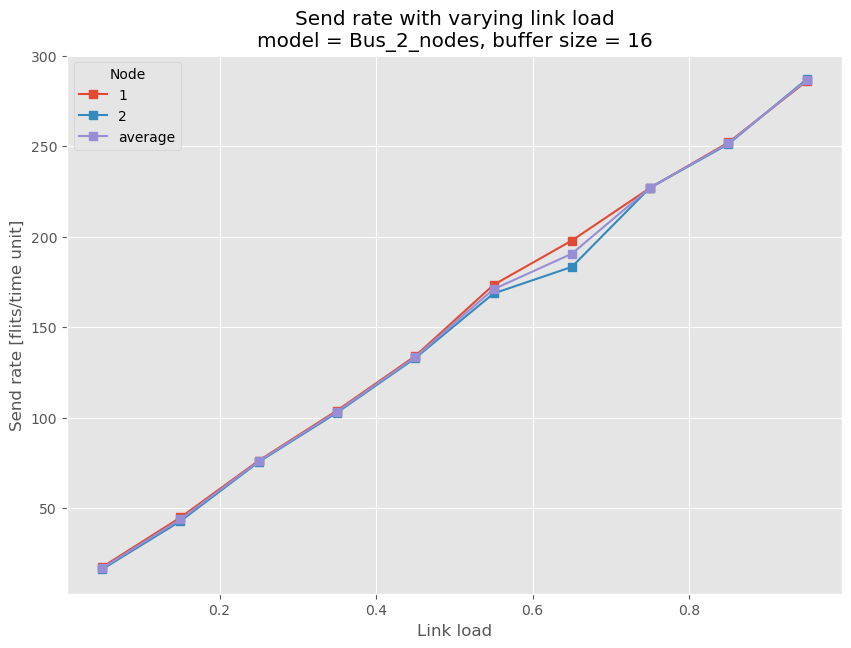

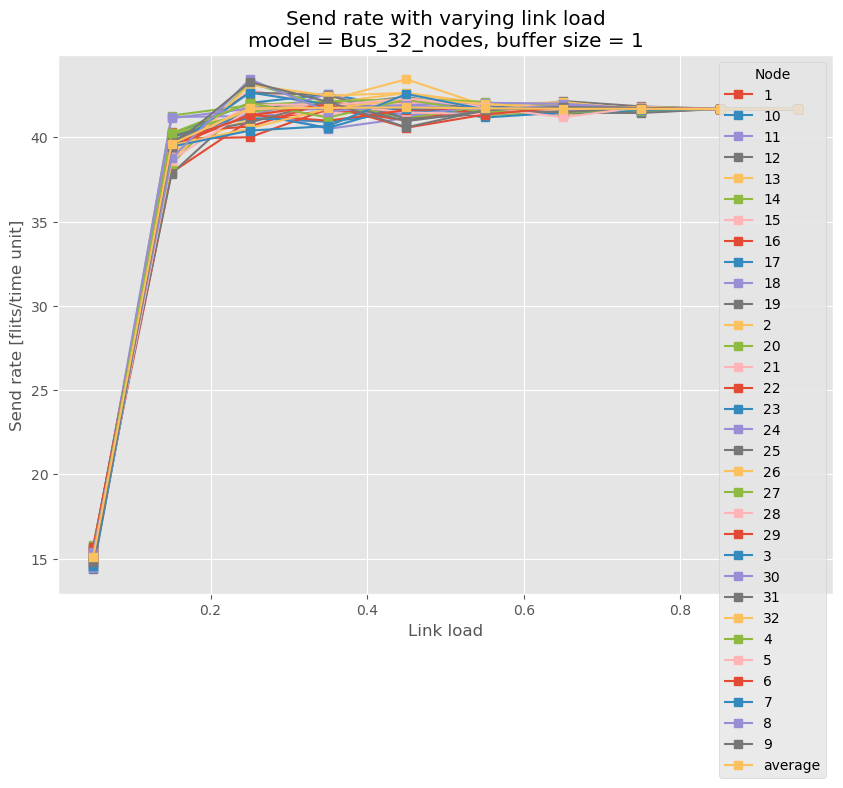

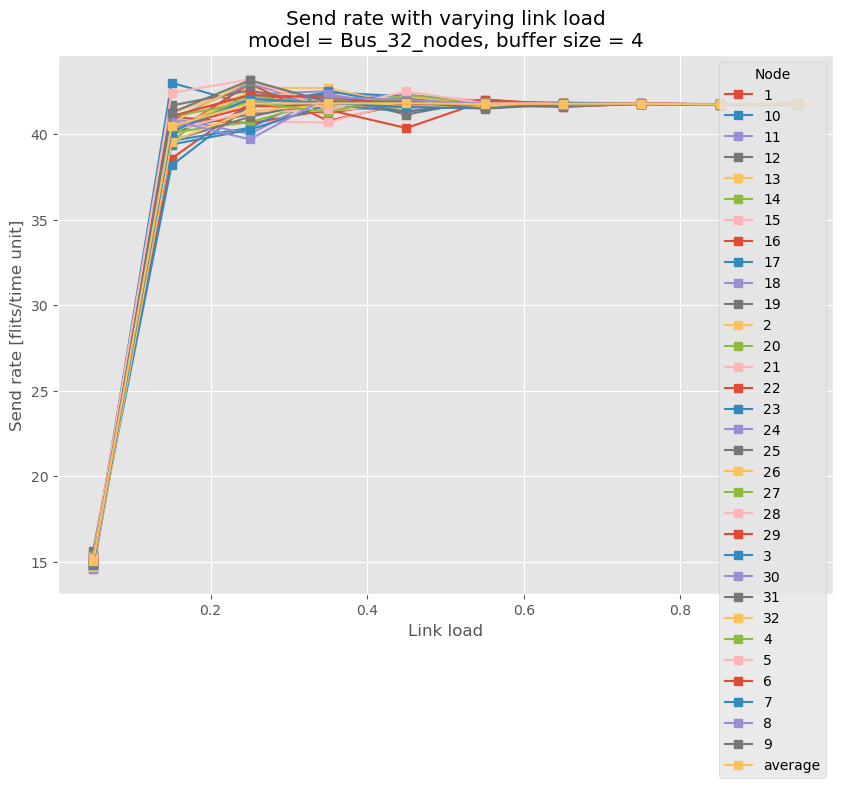

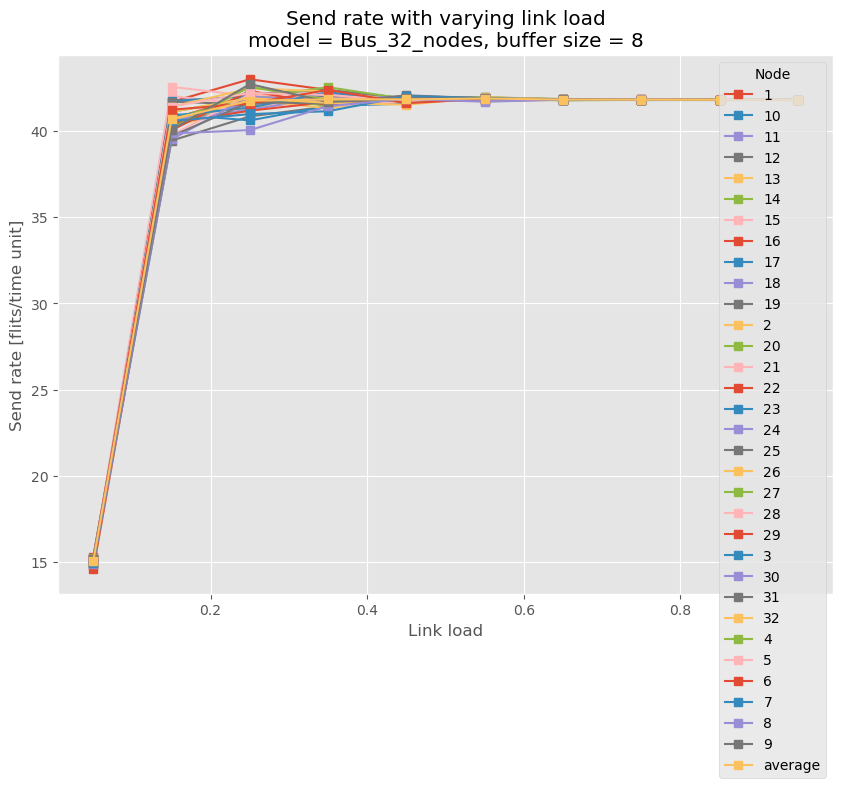

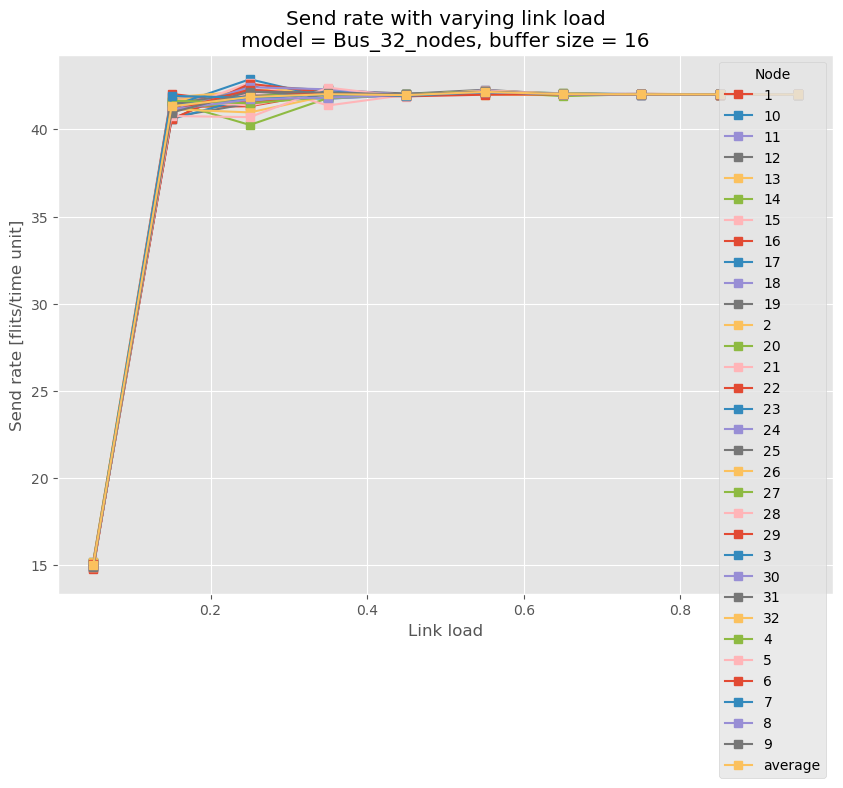

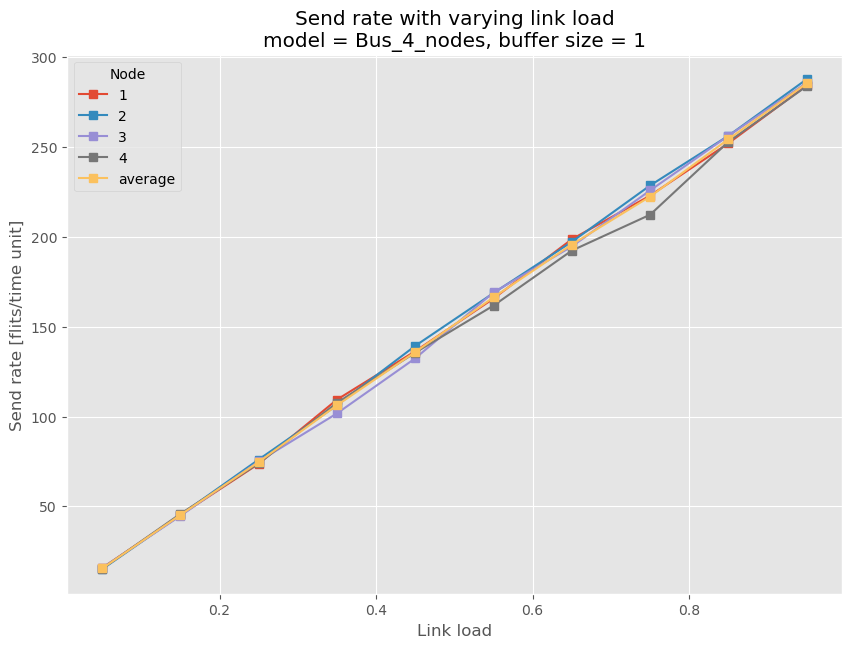

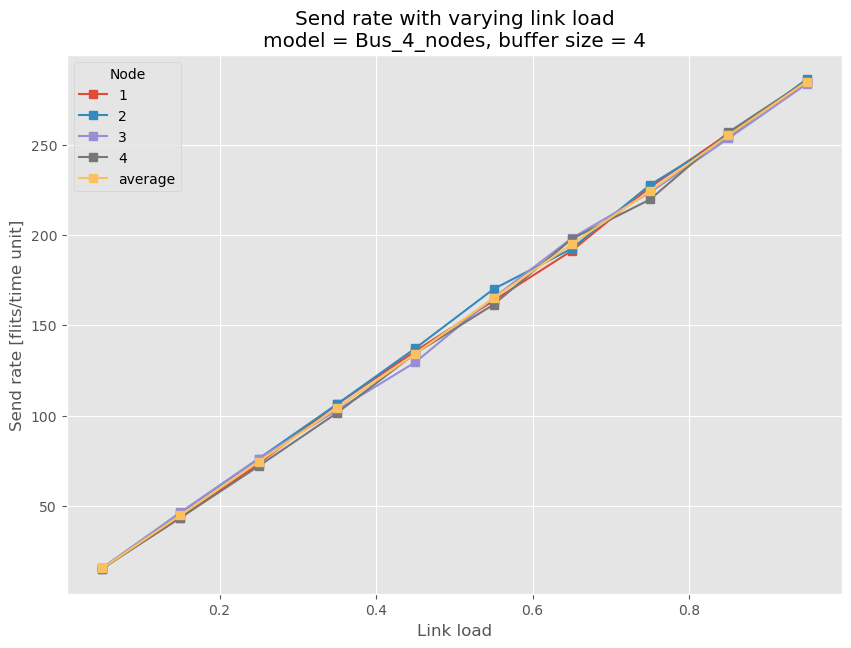

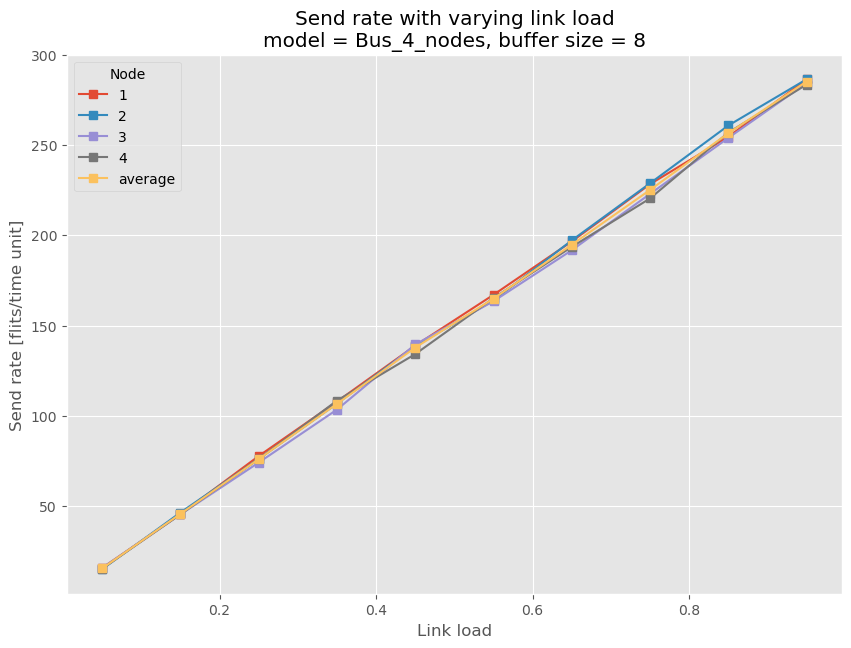

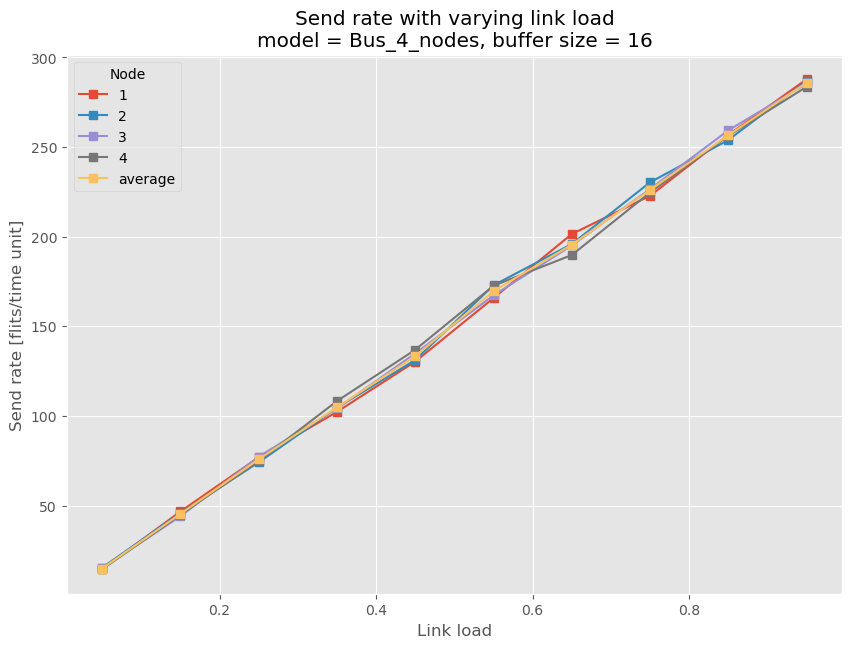

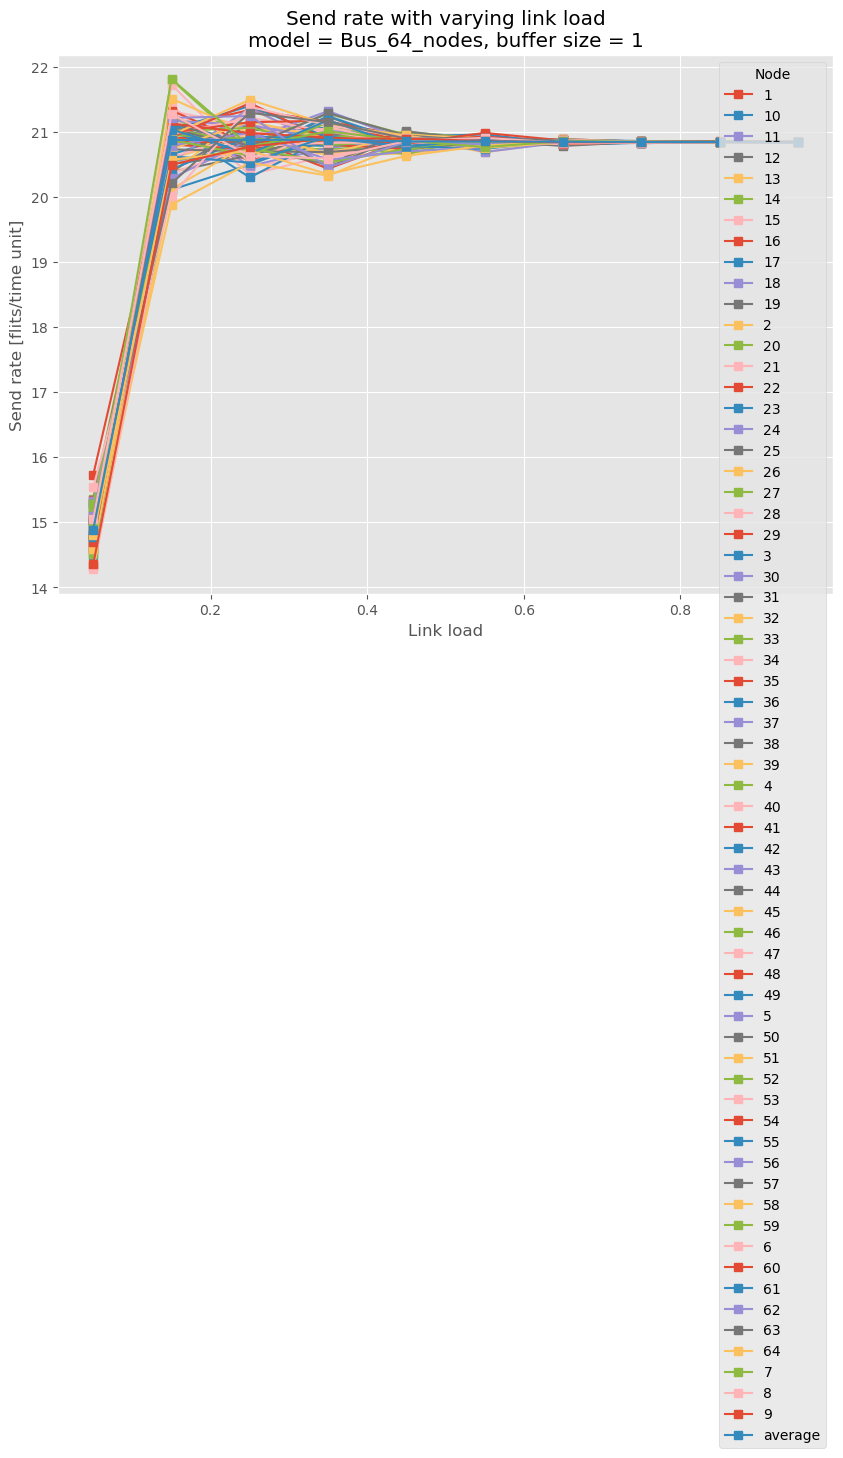

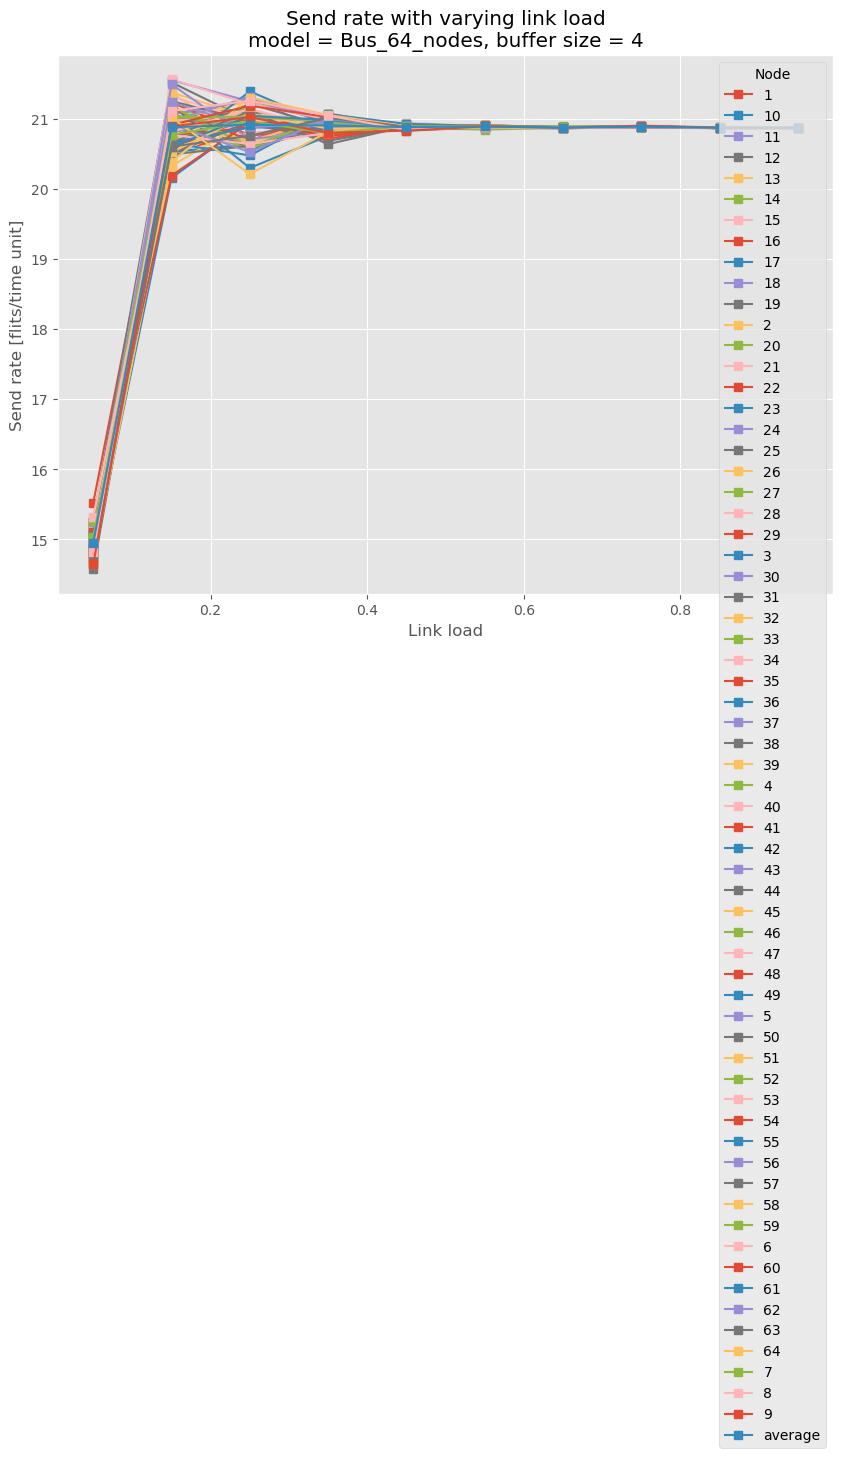

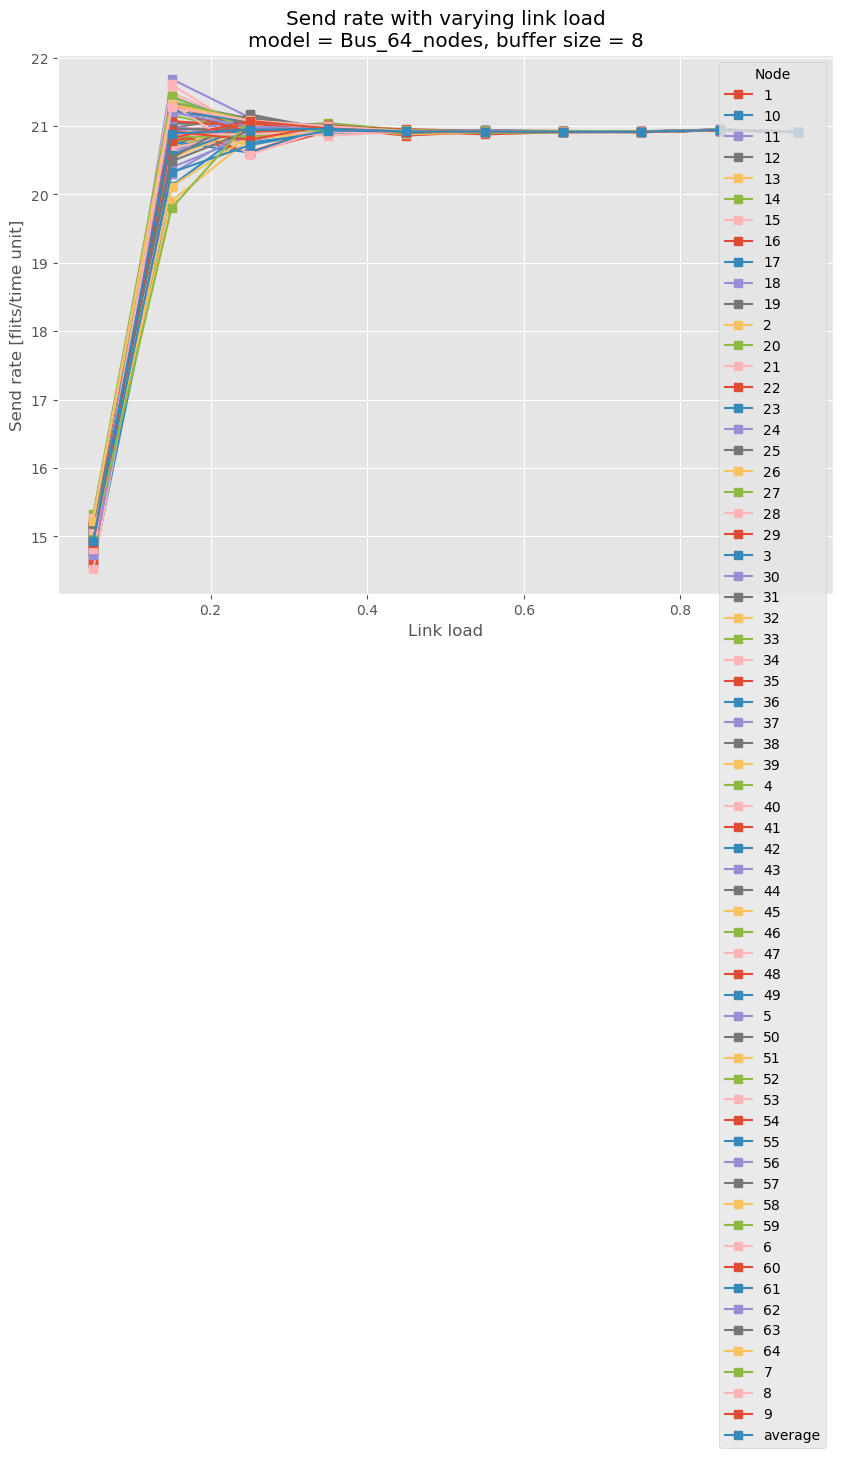

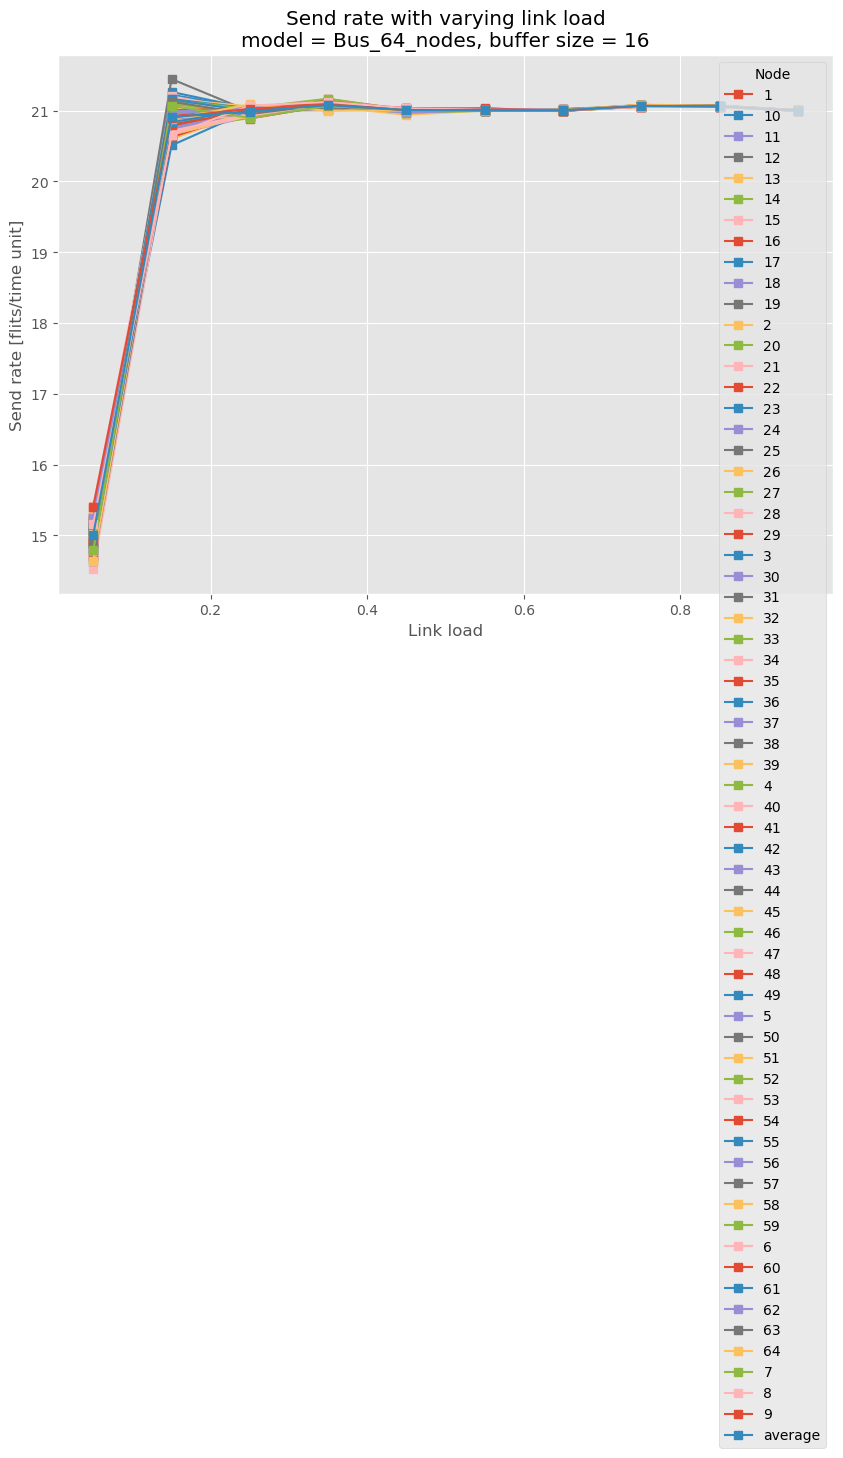

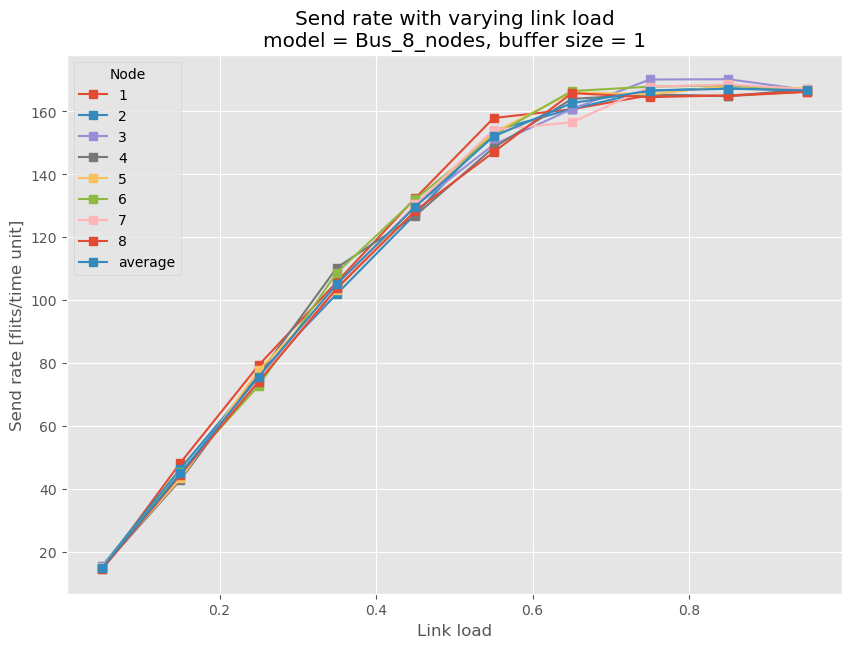

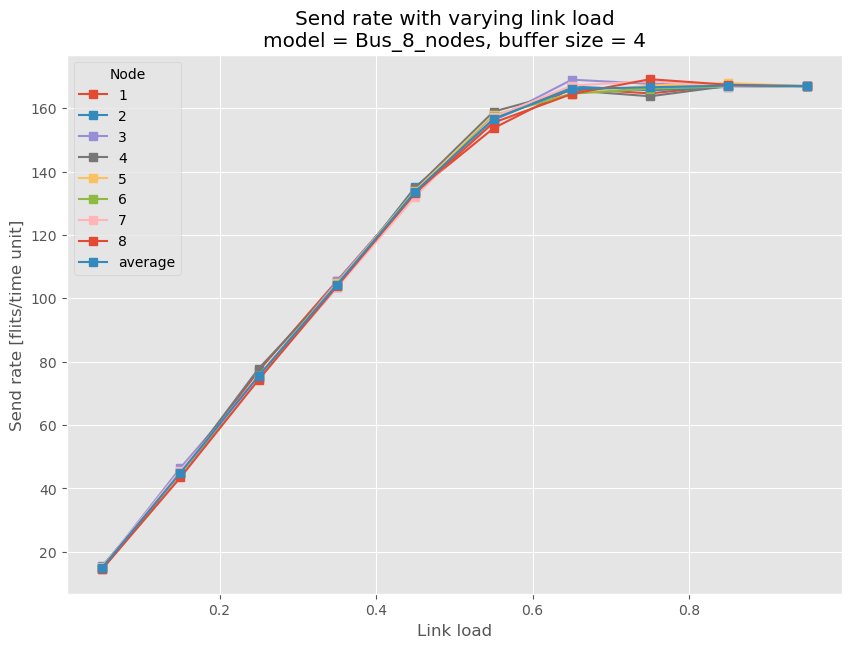

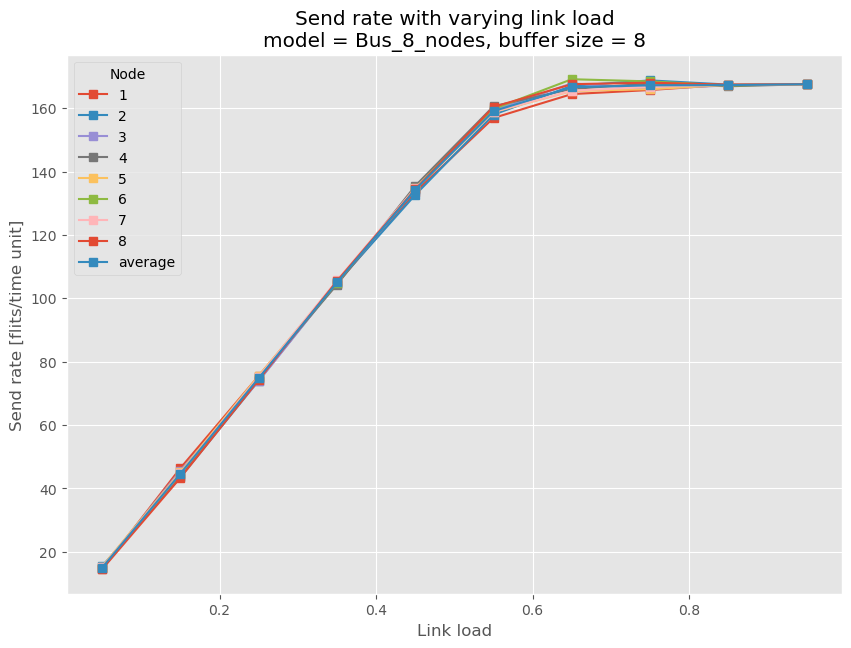

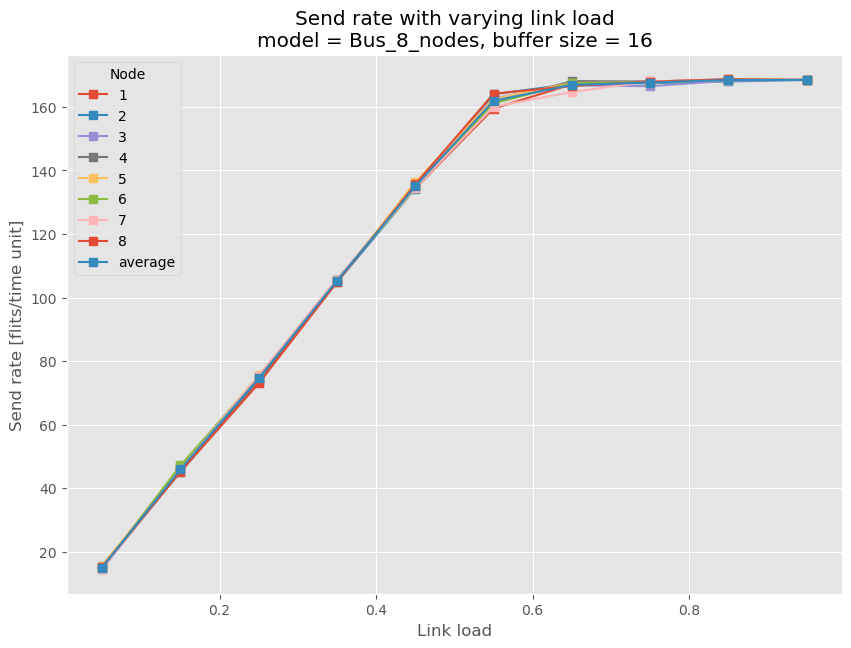

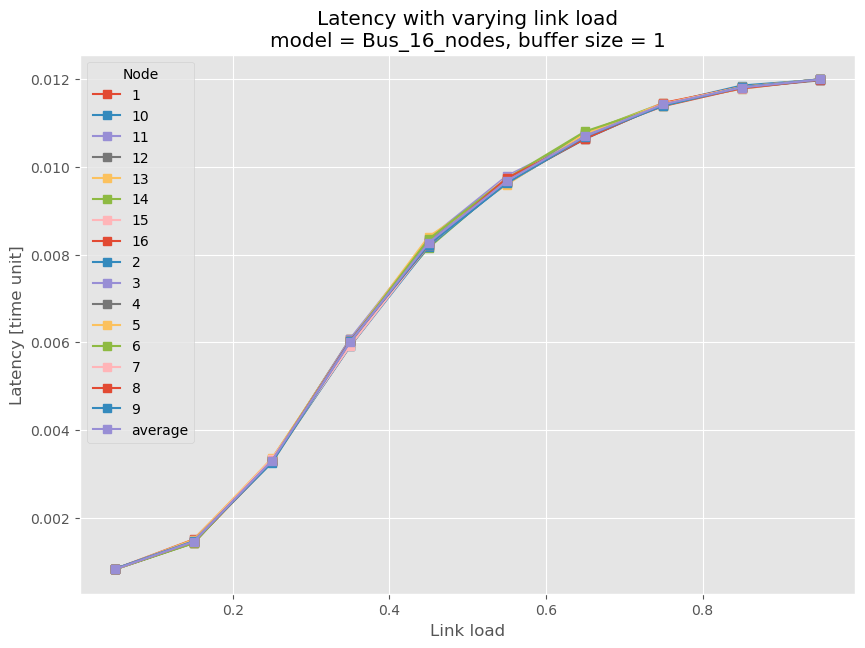

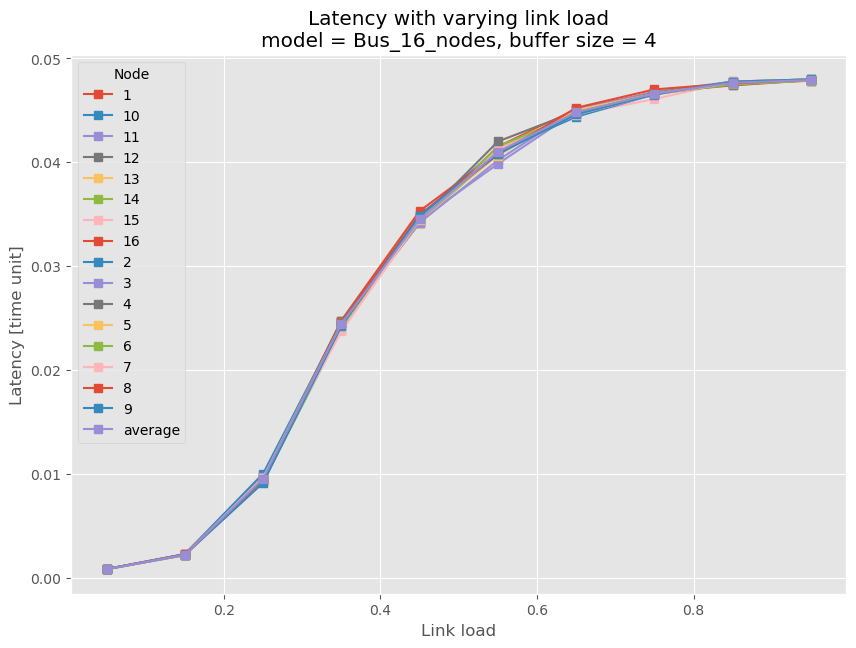

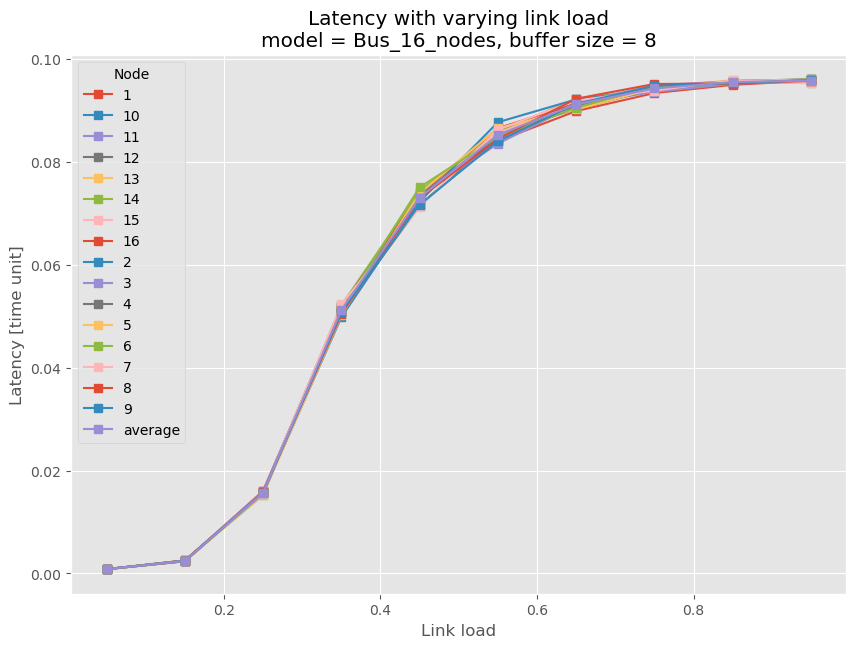

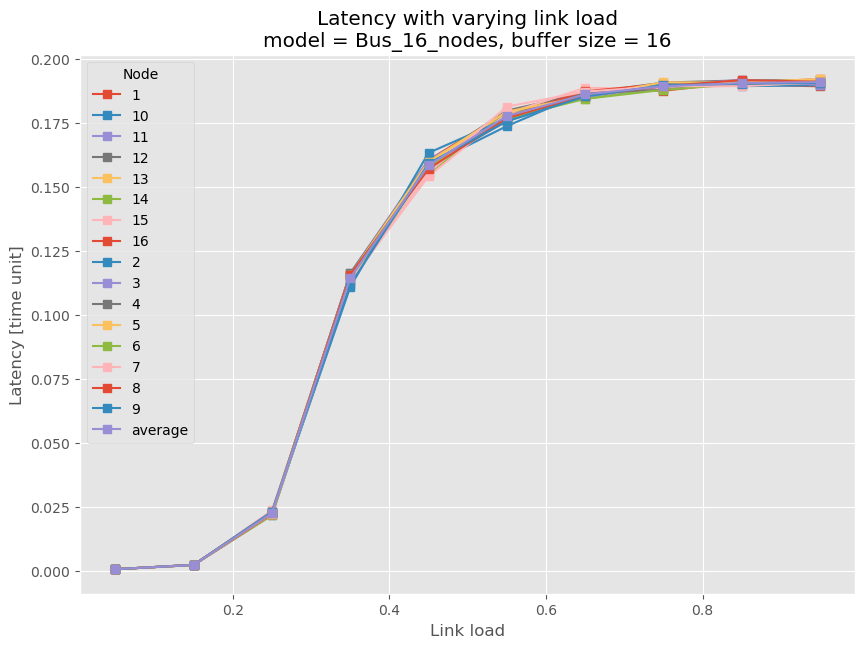

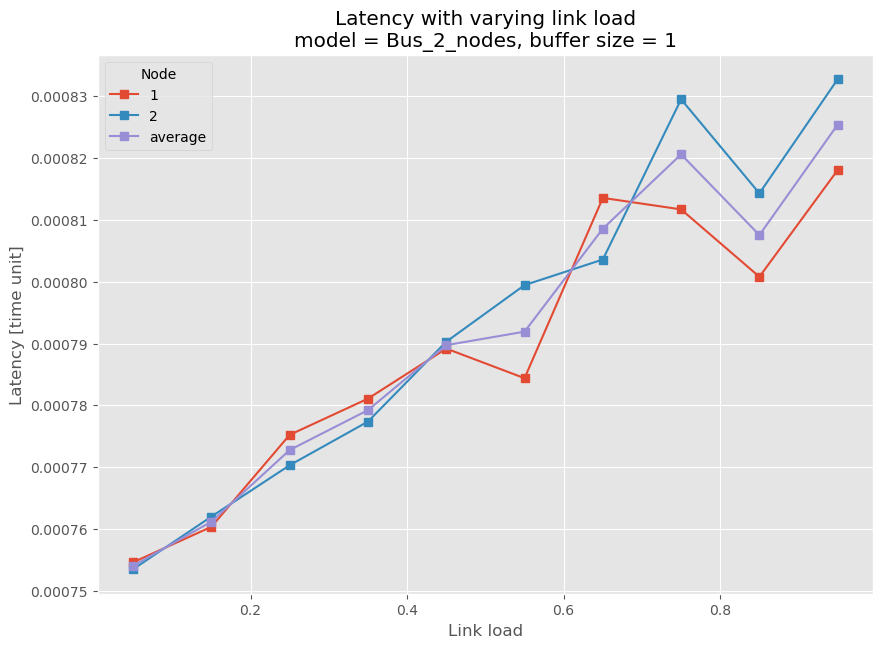

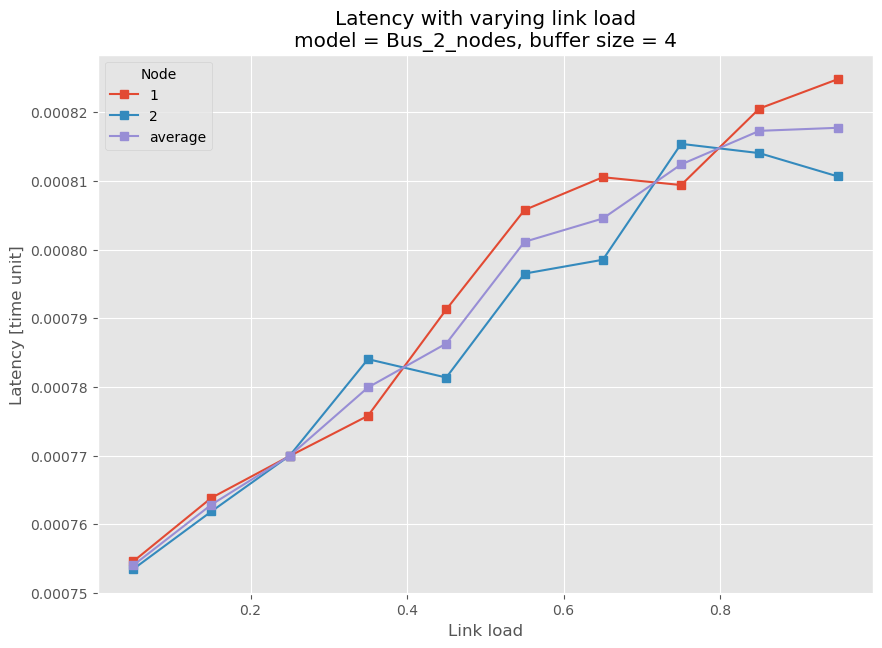

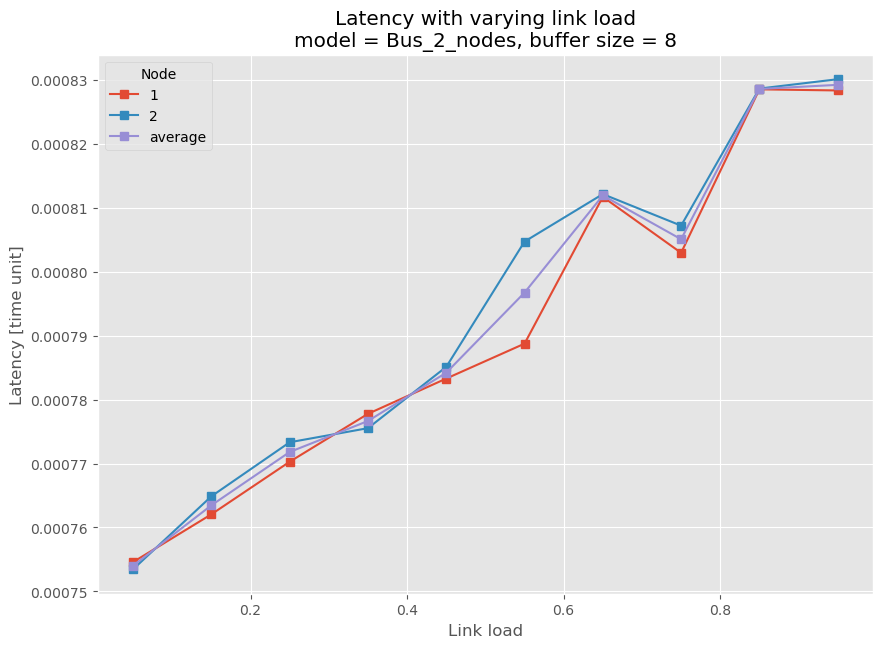

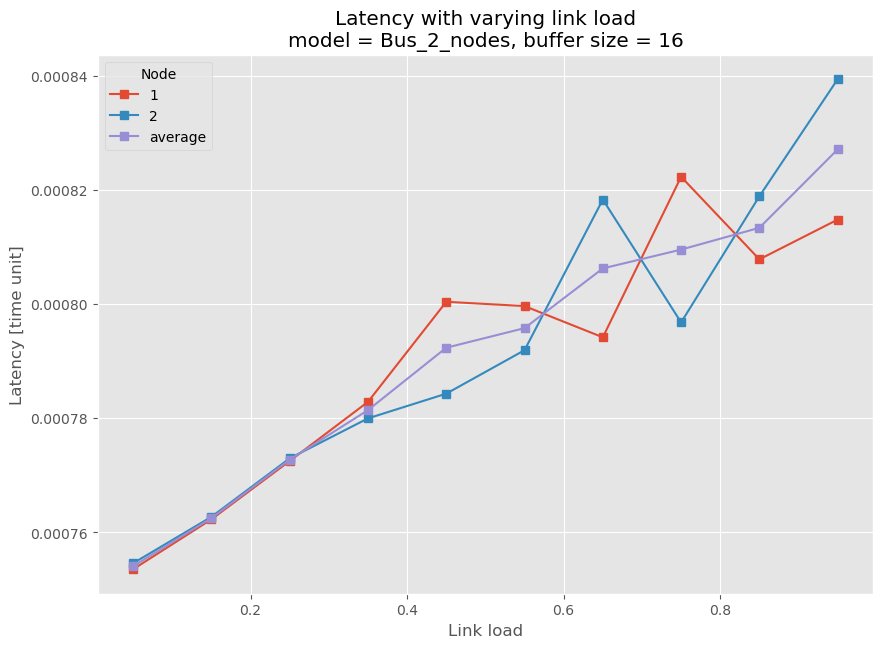

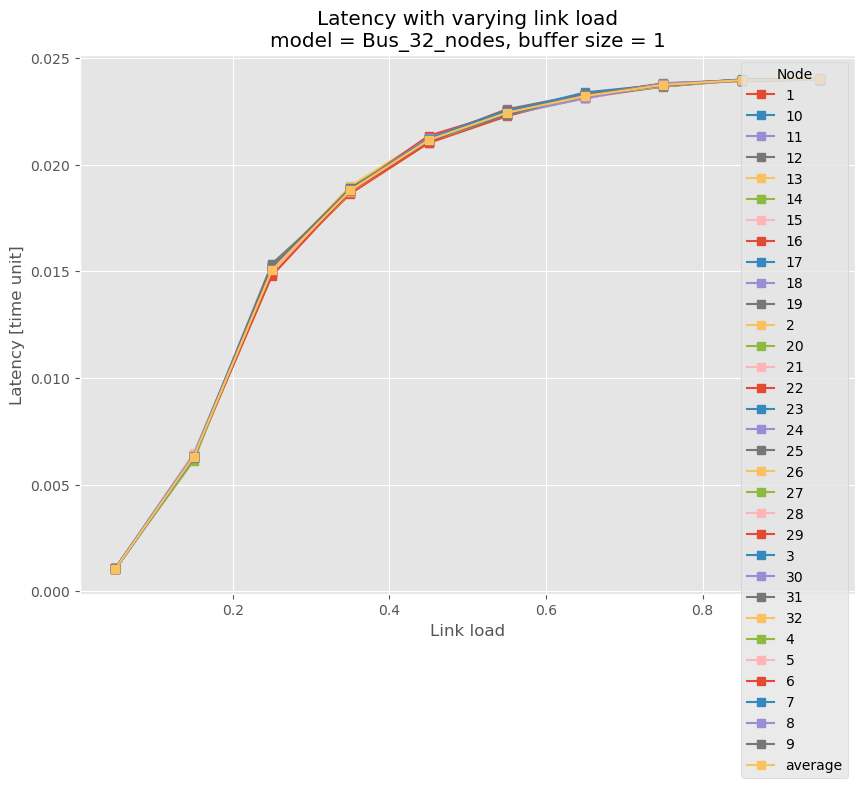

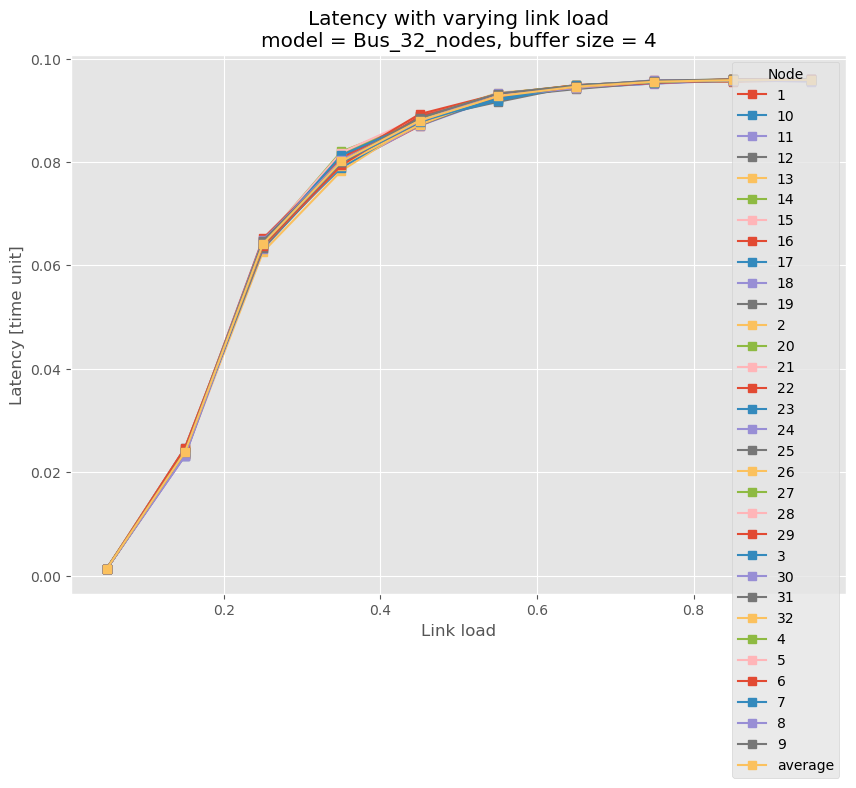

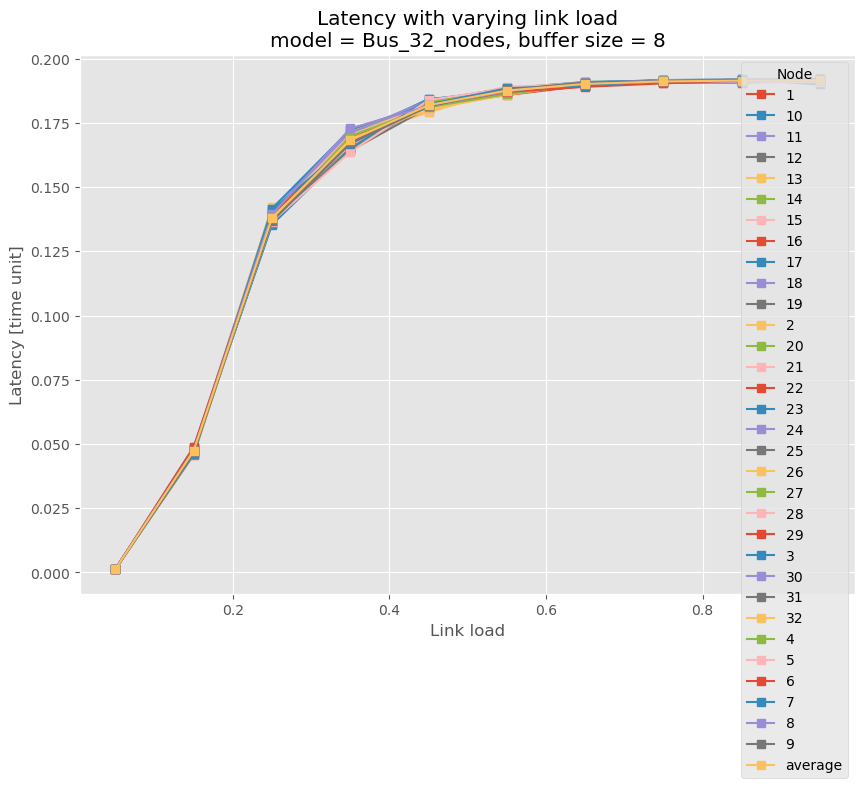

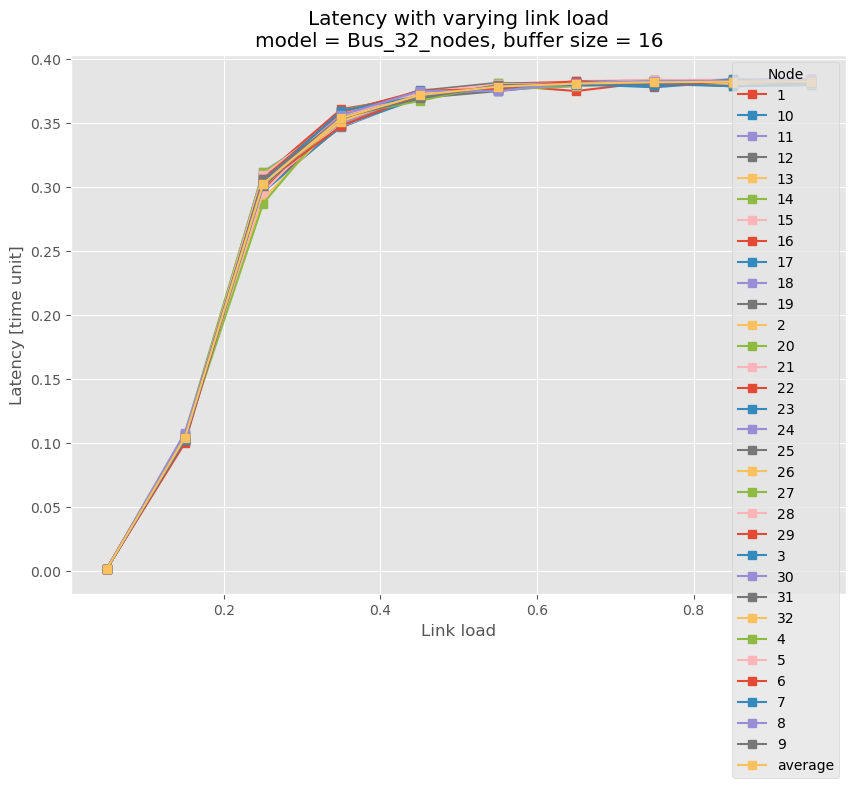

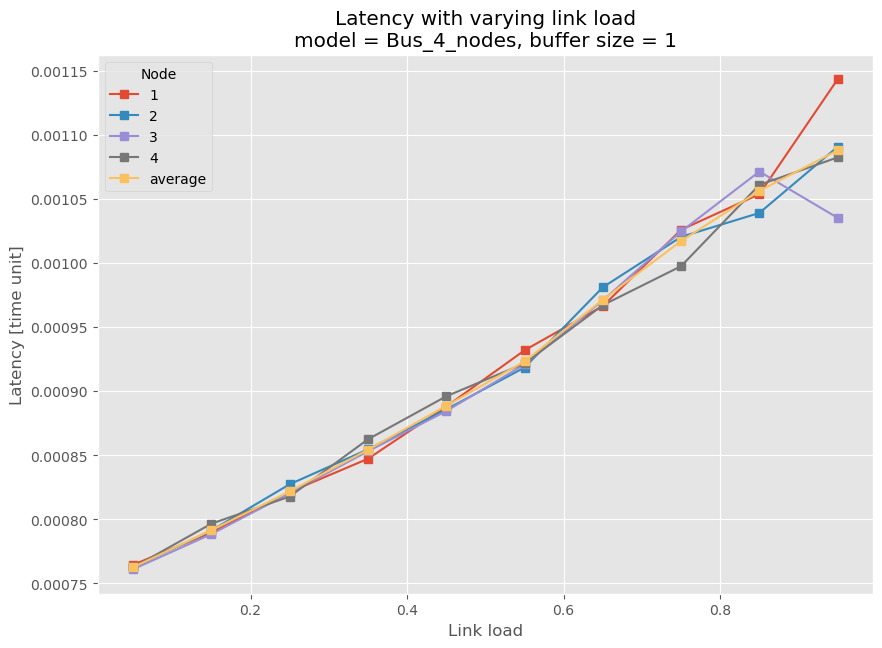

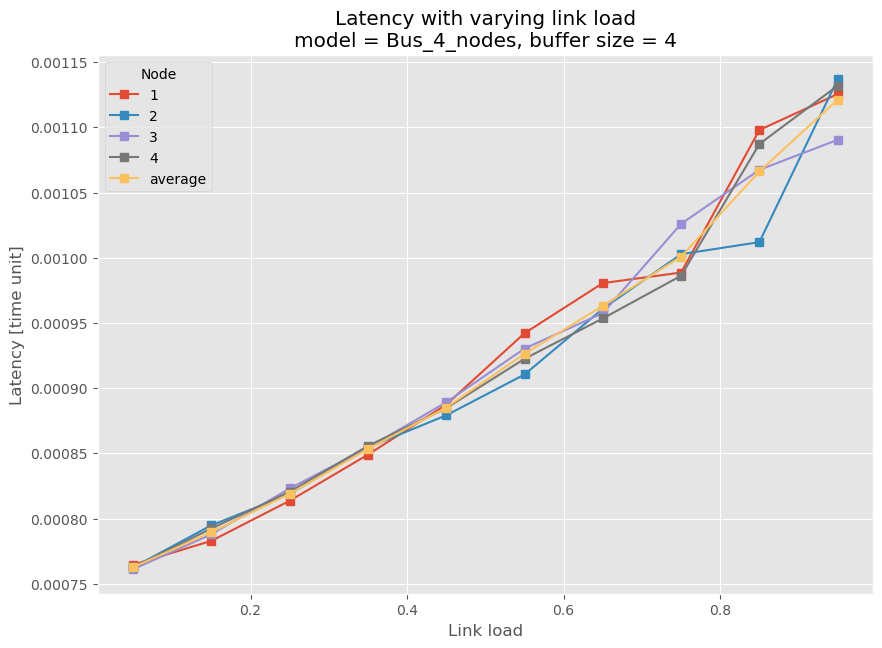

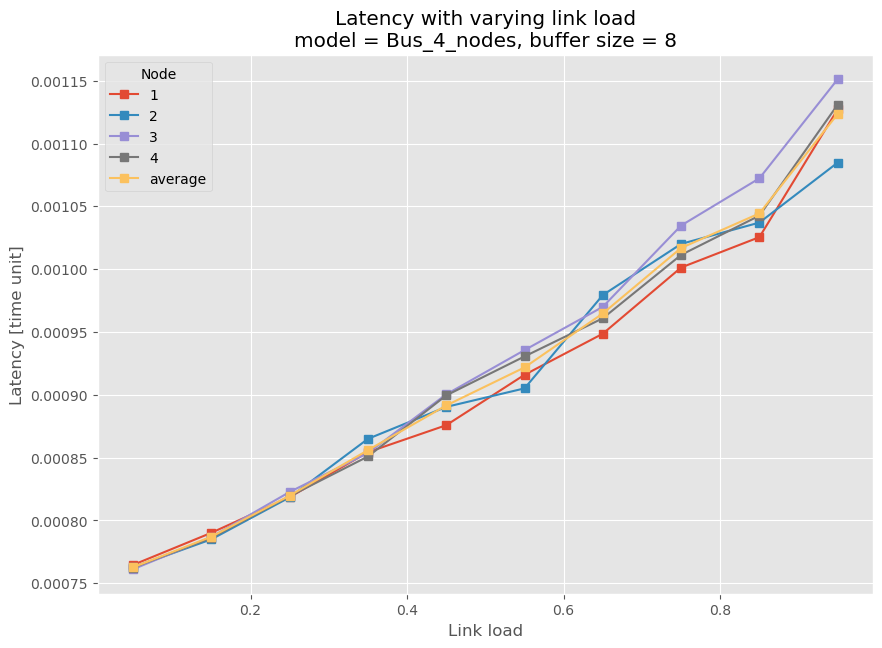

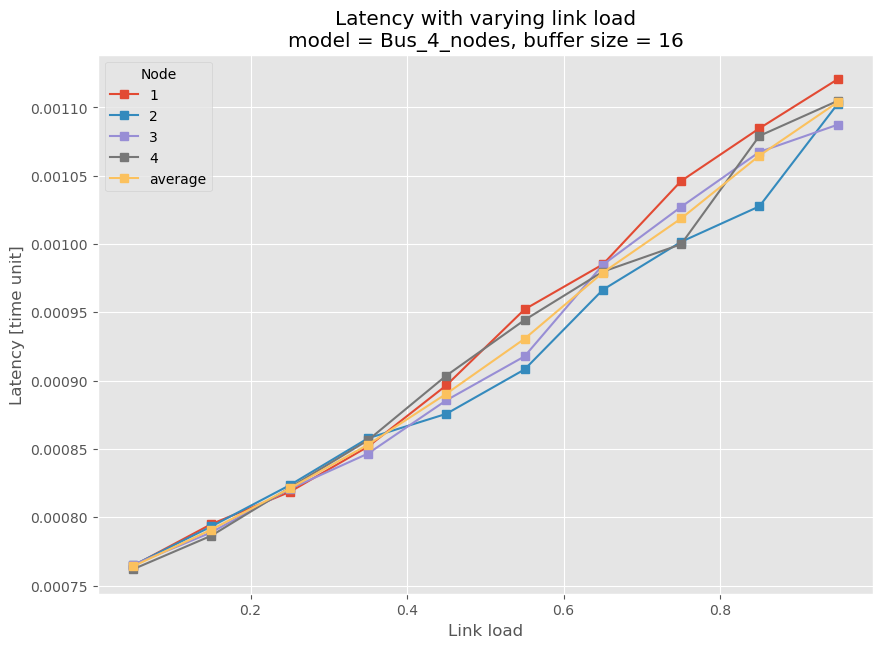

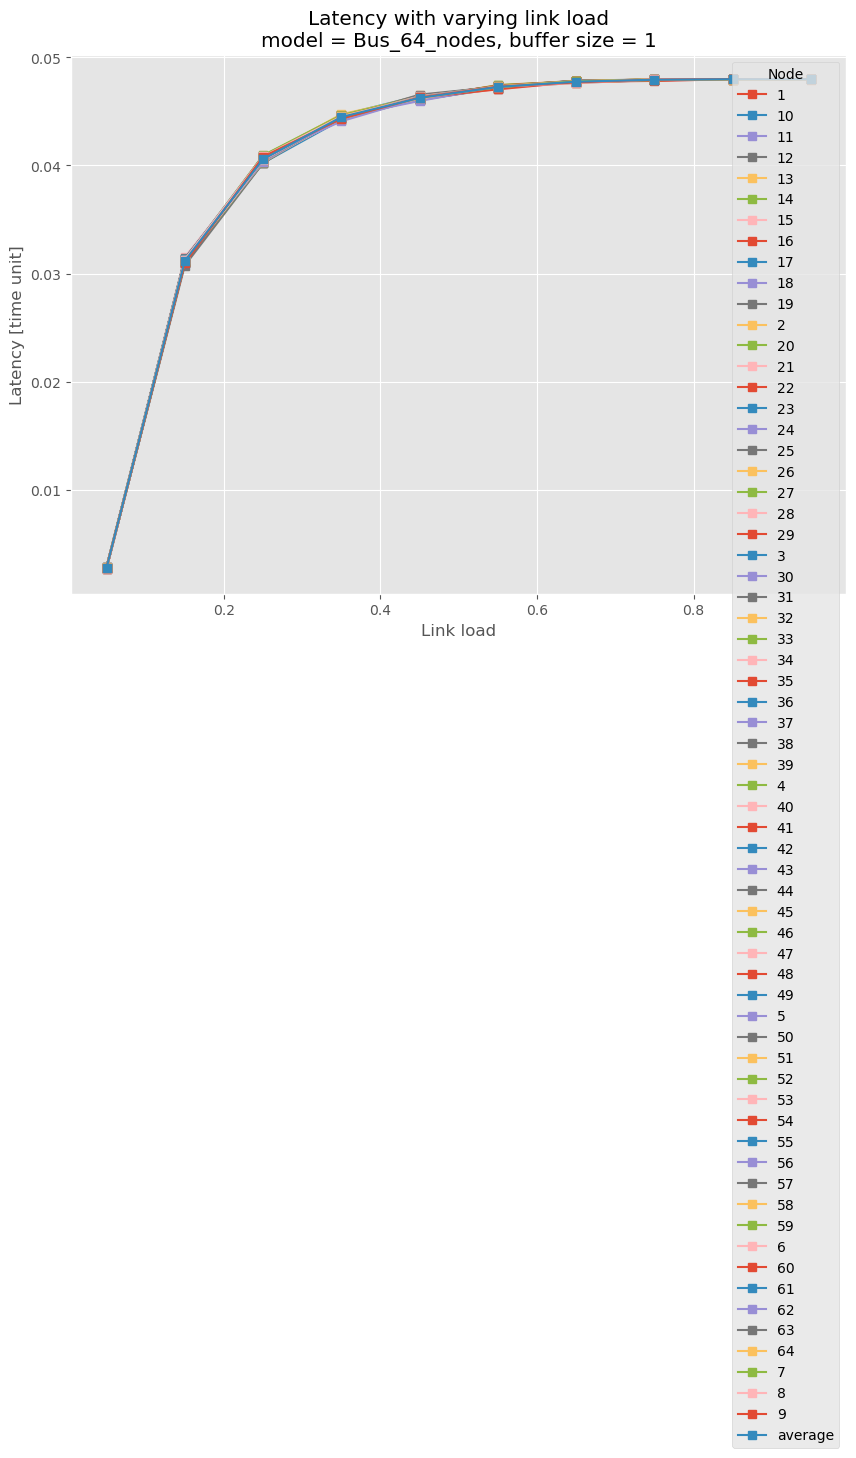

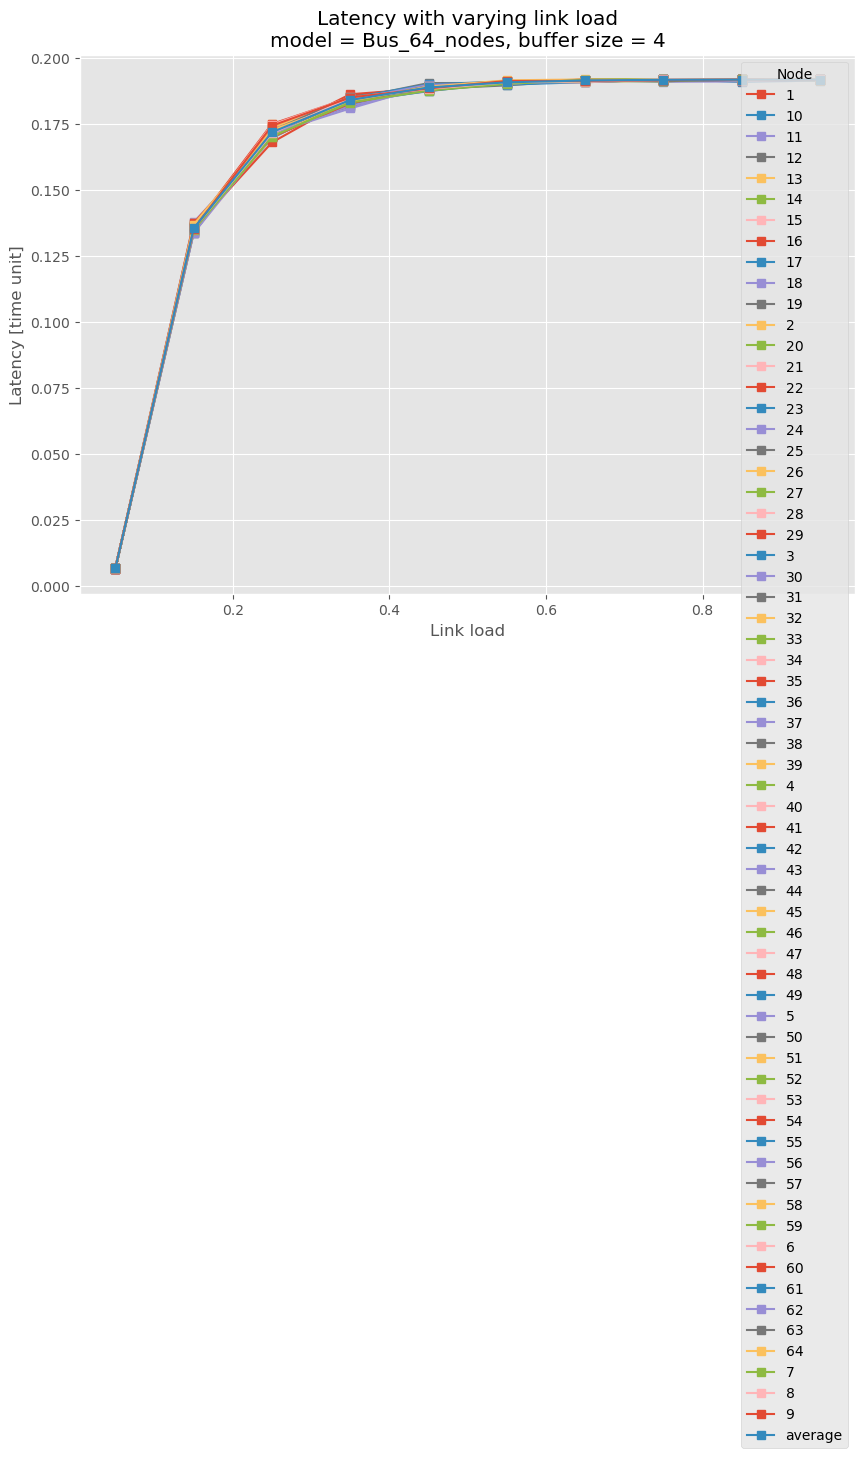

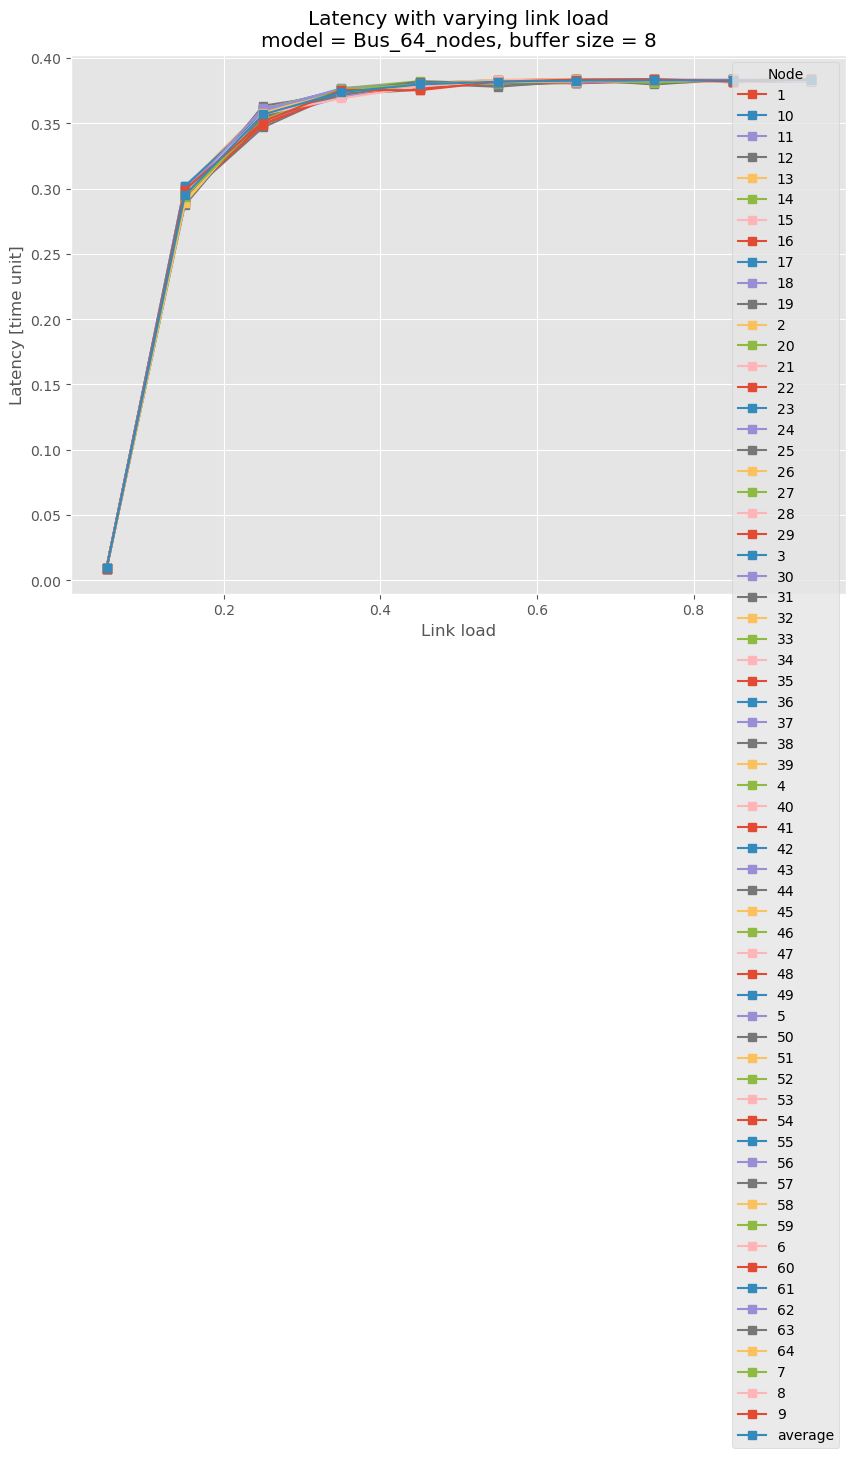

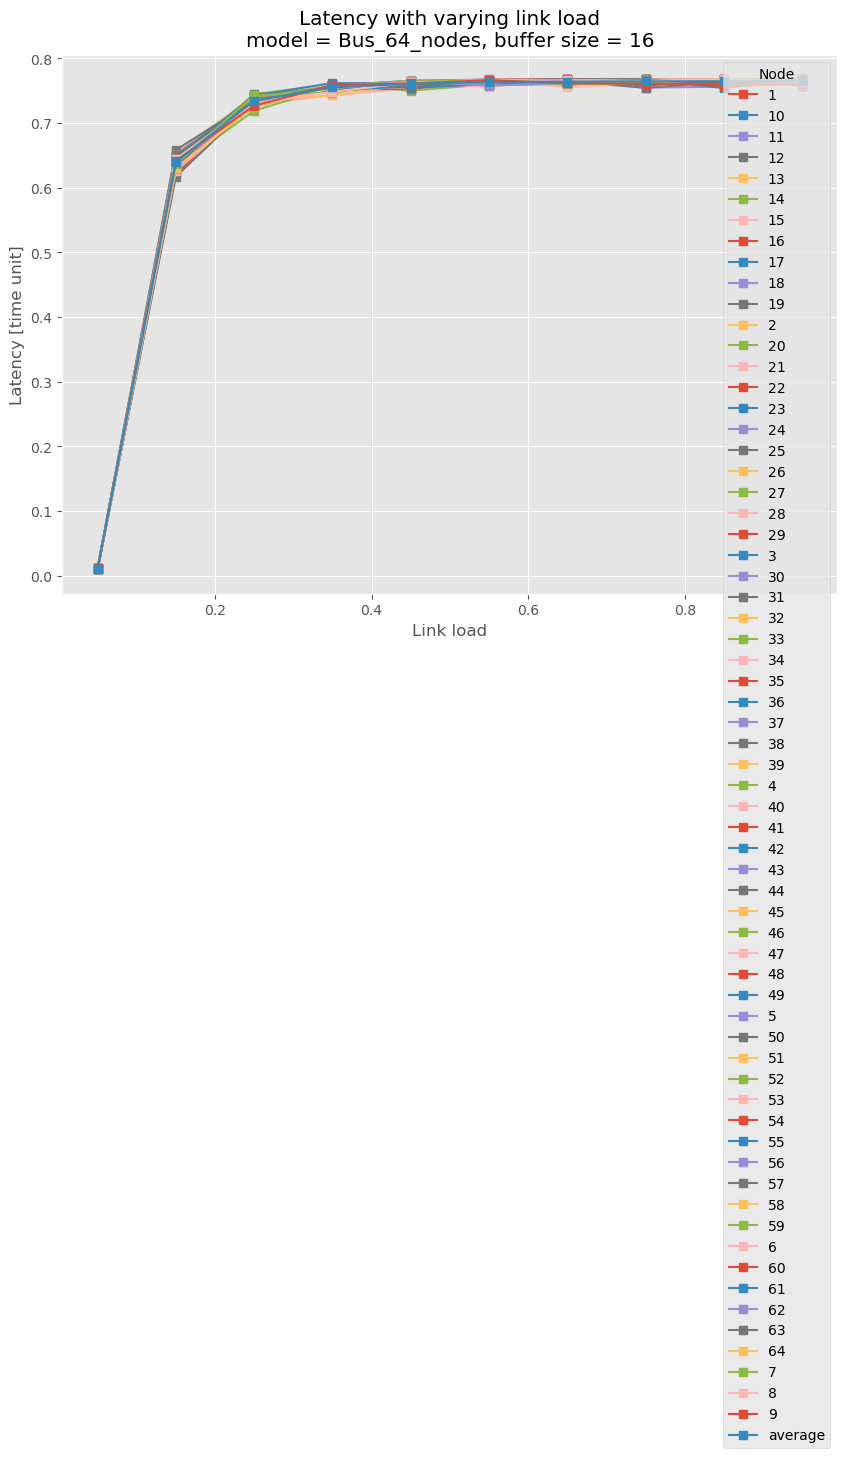

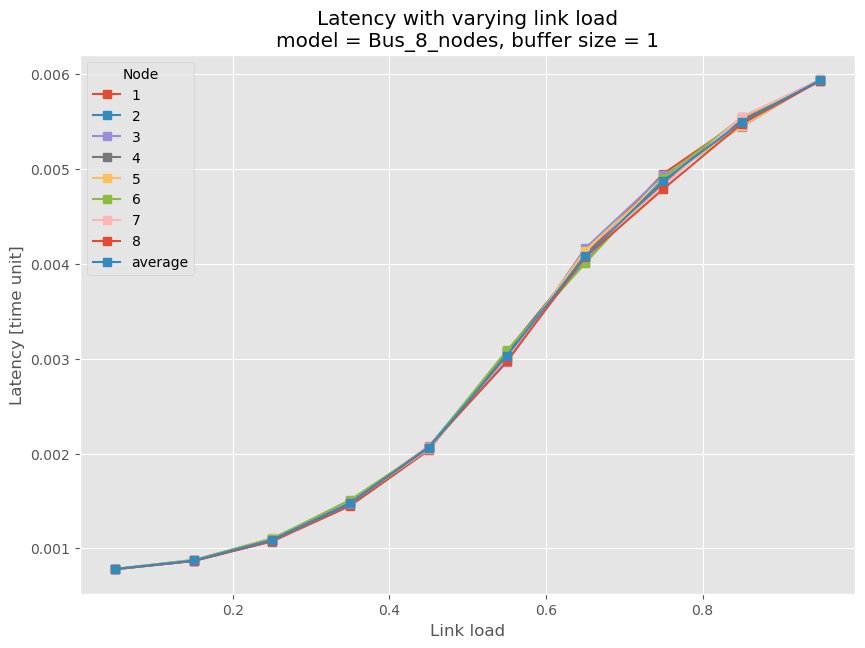

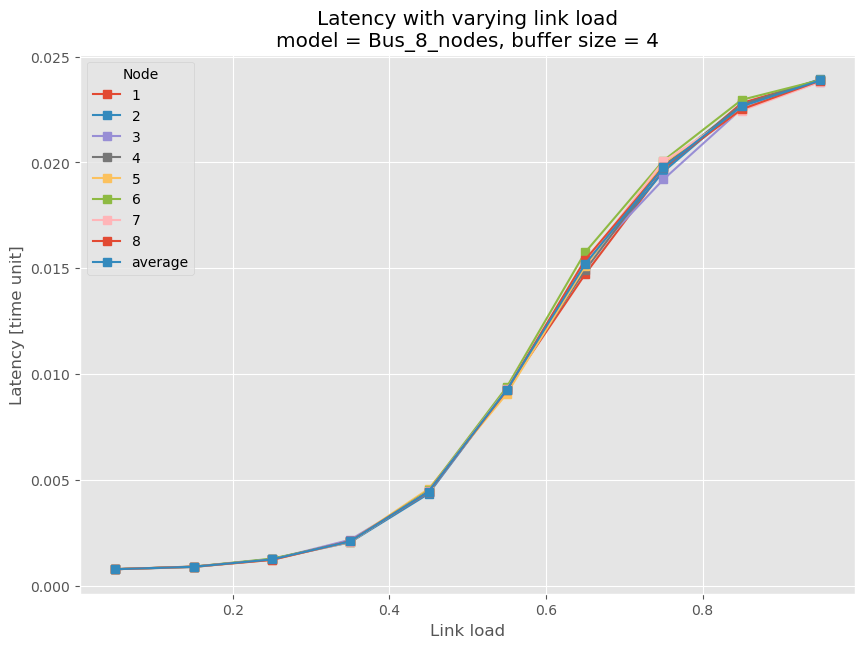

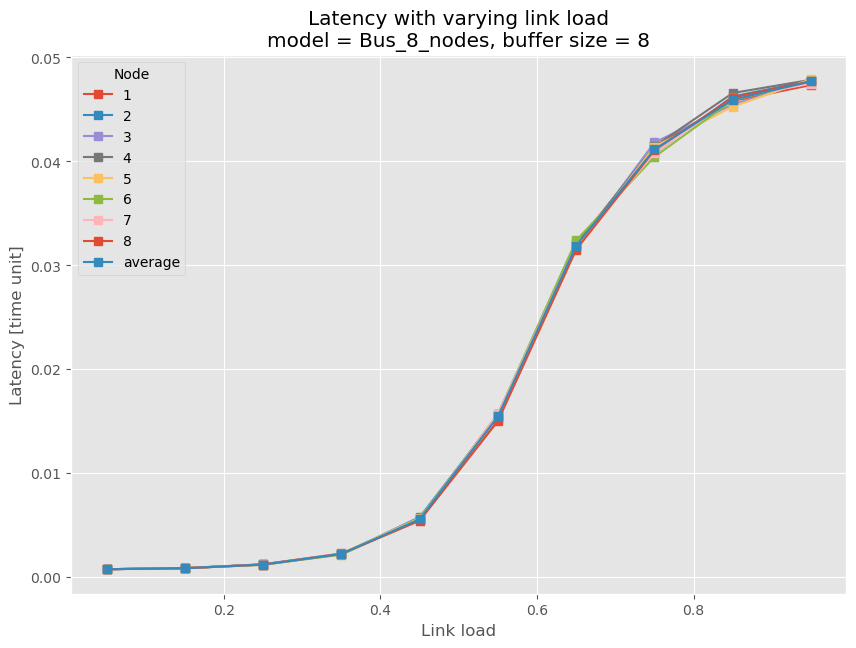

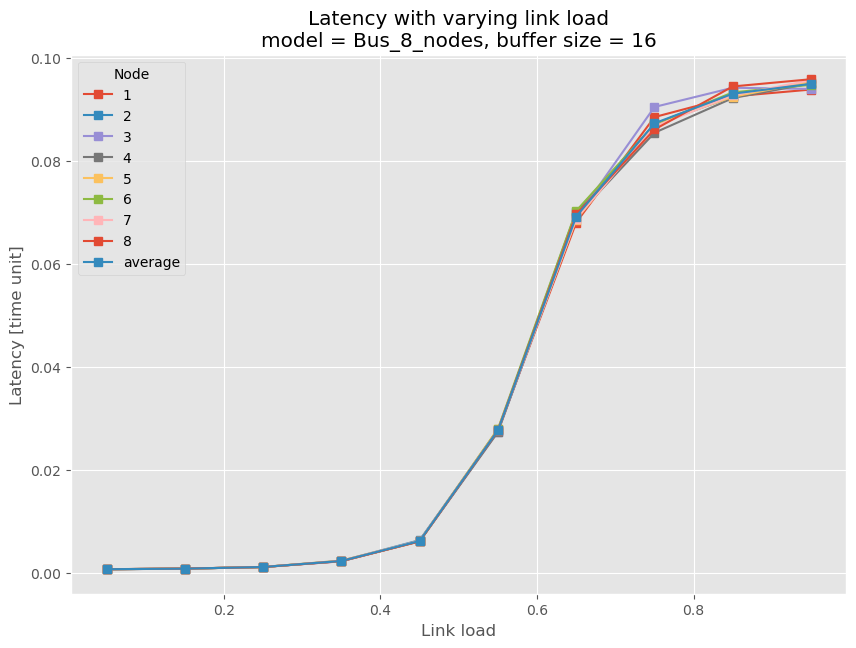

In [22]:
# plot line graphs for each buffer experiment with different load values
for group, df in data["SendRate"].groupby(level=[0,1]):
    line_plot(extract_df(df), 
        f"Send rate with varying link load\nmodel = {group[0]}, buffer size = {group[1]}", 
        'Link load', 'Send rate [flits/time unit]', pdf)
    plt.show()
for group, df in data["Latency"].groupby(level=[0,1]):
    line_plot(extract_df(df), 
        f"Latency with varying link load\nmodel = {group[0]}, buffer size = {group[1]}", 
        'Link load', 'Latency [time unit]', pdf)
    plt.show()

# Plot a subset of the results
You can easily filter out some of the columns, like shown below

In [ ]:
# extract only the rows for which the index correspondes to the first buffer value
latency12_df = data.loc["Bus_4_nodes", 1]["Latency"][["1", "2"]] # select only the Latency1 and Latency2 columns
line_plot(latency12_df, "Link load for Node 1 and 2", 'Link load', 'Latency [time units]', pdf)
plt.show()

# Buffer size  1 2 4 8 16 
# Network size 2 4 8 16 32 64
# Latency
# Send Rate
# Link load 0.05, 0.15, 9.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95


# Show send rate for 0.05 for buffer size 4 and network 1 2 4 8 16
# Show send rate for 0.25 for buffer size 4 and network 1 2 4 8 16
# Show send rate for 0.45 for buffer size 4 and network 1 2 4 8 16
# Show send rate for 0.95 for buffer size 4 and network 1 2 4 8 16
# Show latency for 0.05 for buffer size 4 and network 1 2 4 8 16
# Show latency for 0.25 for buffer size 4 and network 1 2 4 8 16
# Show latency for 0.45 for buffer size 4 and network 1 2 4 8 16
# Show latency for 0.95 for buffer size 4 and network 1 2 4 8 16
for dataType in ["Latency", "SendRate"]:
    for link in ["0.05", "0.25", "0.45", "0.95"]:
        plotData = pd.DataFrame()
        for network in ["Bus_1_nodes", "Bus_2_nodes", "Bus_4_nodes", "Bus_8_nodes", "Bus_16_nodes"]:
            plotData.add(data.loc[network, 1][dataType][["average"]])
                        
        line_plot(plotData, f"Latency of several networks at load {link}", 'Link load', 'Latency [time units]', pdf)
        plt.show()


    df.droplevel([0, 1]).dropna(axis=1, how='all')

for group, df in data["SendRate"].groupby(level=[0,1]):
    line_plot(extract_df(df), 
        f"Send rate with varying link load\nmodel = {group[0]}, buffer size = {group[1]}", 
        'Link load', 'Send rate [flits/time unit]', pdf)
    plt.show()

# Show send rate for 0.05 for buffer size 1 8 16 and network 2 16 and 64
# Show send rate for 0.55 for buffer size 1 8 16 and network 2 16 and 64
# Show send rate for 0.95 for buffer size 1 8 16 and network 2 16 and 64
# Show latency for 0.05 for buffer size 1 8 16 and network 2 16 and 64
# Show latency for 0.55 for buffer size 1 8 16 and network 2 16 and 64
# Show latency for 0.95 for buffer size 1 8 16 and network 2 16 and 64
plotData = pd.DataFrame()
for dataType in ["Latency", "SendRate"]:
    for link in ["0.05", "0.25", "0.45", "0.95"]:
        for network in ["Bus_1_nodes", "Bus_2_nodes", "Bus_4_nodes", "Bus_8_nodes", "Bus_16_nodes"]:
            line_plot(data.loc[network, 1][dataType][["average"]])
    plt.show()



## Save results for future reference

In [ ]:
data.to_csv(output_directory_base / "data.csv")
# load back into dataframe by using: df = pandas.read_csv('data.csv', index_col=[0,1,2], header=[0,1])

if pdf != None:
    pdf.close()
pdf = None  # remove the reference to the multipage PDF
